<a href="https://colab.research.google.com/github/Walt9819/factores-impacto-desempleo-mexico/blob/main/AD_Python/restaurantes_cdmx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recuperación económica post-COVID: Localización óptima de restaurantes en México**

# **Módulo 4:  Análisis de datos con Python**

## **Conjuntos de datos**
La información explorada para este proyecto y módulo esta conformada por:
*   Encuesta intercensal 2015
*   Censos económicos 2019
*   ENOE 2020q4
*   DENUE


## **Definición de módulos**

In [1]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 6.7MB/s 
     |████████████████████████████████| 6.5MB 16.3MB/s 
     |████████████████████████████████| 15.3MB 278kB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import geopandas

import locale
from datetime import datetime
import plotly.express as px
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import dateutil

## **Integración de los conjuntos de datos**

1.   Lectura de archivo CSV con datos referentes al número de restaurantes agregados por municipios. Fuente: **DENUE**




In [3]:
denue = pd.read_csv(r"https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/AD_Python/data/denue_final.csv", sep = ';')
denue

,Unnamed: 0,cve_ent_mun,Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida,Restaurantes con servicio de preparación de antojitos,Restaurantes con servicio de preparación de pescados y mariscos,"Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar",Restaurantes con servicio de preparación de tacos y tortas,Restaurantes de autoservicio,Restaurantes que preparan otro tipo de alimentos para llevar
0,0,10001,9.0,54.0,4.0,13.0,15.0,2.0,7.0
1,1,10002,4.0,2.0,0.0,2.0,1.0,0.0,0.0
2,2,10003,1.0,3.0,0.0,0.0,1.0,0.0,0.0
3,3,10004,14.0,61.0,5.0,20.0,18.0,2.0,8.0
4,4,10005,244.0,1500.0,141.0,394.0,480.0,67.0,197.0
...,...,...,...,...,...,...,...,...,...
2401,2401,9013,157.0,547.0,58.0,181.0,332.0,27.0,364.0
2402,2402,9014,1108.0,308.0,111.0,251.0,739.0,113.0,367.0
2403,2403,9015,2018.0,804.0,204.0,377.0,1448.0,209.0,945.0
2404,2404,9016,904.0,468.0,117.0,163.0,644.0,99.0,420.0


In [4]:
denue.columns = ['idx', 'imun',
       'comida_carta_corrida',
       'antojitos',
       'pescados_mariscos',
       'pizzas_hamburguesas_hotdogs_pollos_rostizados',
       'tacos_tortas',
       'autoservicio',
       'otro_tipo_alimentos']

2.   Lectura de los indicadores socioeconómicos por municipio. Fuente: **ENOE**

In [5]:
indicadores_socioeconomicos = pd.read_csv(r"https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/AD_Python/data/indicadores_socioeconomicos.csv")
indicadores_socioeconomicos

,id_ent_mun,municipio,ing_lab,ocupados,desocupados,pob,pob_muj,pob_hom,pob_0_4,pob_5_9,pob_10_14,pob_15_19,pob_20_24,pob_25_29,pob_30_34,pob_35_39,pob_40_44,pob_45_49,pob_50_54,pob_55_59,pob_60_64,pob_65_more
0,1001,Aguascalientes,7676.46,300564.0,24836.0,974529,496496,478033,76830,81212,84814,87843,87717,85136,77028,68786,63800,61048,54146,45343,35638,65188
1,1002,Asientos,5863.52,8138.0,693.0,51383,25810,25573,4987,5181,5240,5115,4749,4380,3830,3223,2819,2591,2184,1783,1481,3820
2,1003,Calvillo,5784.97,14757.0,199.0,61389,31334,30055,5465,5612,5795,5733,5207,4738,4288,3737,3321,3223,3052,2765,2455,5998
3,1004,Cosío,6096.05,3801.0,87.0,17076,8690,8386,1588,1718,1755,1698,1526,1371,1237,1096,977,898,768,642,531,1271
4,1005,Jesús María,6262.18,37341.0,3187.0,132340,65849,66491,13140,13685,13427,12657,11812,11645,11355,10216,8478,6853,5299,4198,3361,6214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,32054,Villa Hidalgo,1877.31,7685.0,NaN,20278,10200,10078,2051,2097,2102,1977,1704,1536,1463,1356,1178,1032,905,782,635,1460
2453,32055,Villanueva,NaN,NaN,NaN,31980,16307,15673,2705,2784,2790,2639,2337,2193,2098,1954,1821,1795,1757,1657,1482,3968
2454,32056,Zacatecas,7421.03,48024.0,3552.0,156434,80352,76082,12439,12814,12587,13280,14030,13834,12467,11058,10165,10017,9459,8241,6230,9813
2455,32057,Trancoso,6537.04,7025.0,281.0,20440,10323,10117,2204,2236,2117,1979,1830,1718,1547,1341,1169,1058,914,716,516,1095


In [6]:
indicadores_socioeconomicos.columns = ['imun', 'municipio', 'ing_lab', 'ocupados', 'desocupados', 'pob',
       'pob_muj', 'pob_hom', 'pob_0_4', 'pob_5_9', 'pob_10_14', 'pob_15_19',
       'pob_20_24', 'pob_25_29', 'pob_30_34', 'pob_35_39', 'pob_40_44',
       'pob_45_49', 'pob_50_54', 'pob_55_59', 'pob_60_64', 'pob_65_more']

3.   Lectura de los indicadores sociodemográficos por municipio. Fuente: **INEGI**



In [7]:
dataframe = pd.read_csv(r"https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/AD_Python/data/Indicadores_INEGI_covid19.csv", encoding = 'ISO-8859-1')
dataframe

,imun,ent,nom_ent,mun,nom_mun,pobtot,pob_m,pob_f,pob60,pob60_m,pob60_f,pob00_24,pob25_59,i_envejeci,p_pob_m,p_pob_f,p_pob60,p_pob60_m,p_pob60_f,p_pob00_24,p_pob25_59,afrodesc,hlengua,p_afrodesc,p_hlengua,asis3_5,asis3_5m,asis3_5f,asis6_11,asis6_11m,asis6_11f,asis12_14,asis12_14m,asis12_14f,asis15_17,asis18_24,prom_esc,p_asis3_5,p_asis3_5m,p_asis3_5f,...,p_tv,p_celular,p_internet,dens_consh,dens_camah,td_neumoni,td_influen,td_corazon,td_diabete,td_hiperte,td_respcro,p_obes20,p_obes60,p_hipert20,p_hipert60,p_diabet20,p_diabet60,p_obht20,p_obht60,p_sobhtd20,tot_est,est_e_a,est_e_p,est_n_e_a,est_n_e_p,tot_p_o,po_e_a,po_e_p,po_n_e_a,po_n_e_p,tot_po_h,tot_p_h_e_a,tot_p_h_e_p,tot_p_h_n_e_a,tot_p_h_n_e_p,tot_po_m,tot_p_m_e_a,tot_p_m_e_p,tot_p_m_n_e_a,tot_p_m_n_e_p
0,0,0,Estados Unidos Mexicanos,NaN,Total,119530753.0,58056133.0,61474620.0,12436321.0,5750299.0,6686022.0,54189673.0,52817990.0,26.10,48.57,51.43,10.40,46.24,53.76,45.34,44.19,1381853.0,7382785.0,1.16,6.52,4134339.0,2085665.0,2048674.0,12921177.0,6547702.0,6373475.0,6358021.0,3198257.0,3159764.0,4730969.0,4711637.0,9.16,62.99,31.78,31.21,...,92.90,78.53,32.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.07,33.75,18.38,42.37,10.32,25.09,10.52,19.25,5.15,6269309,3381133,53.93,2888175,46.07,35463625,17199988,48.50,18263637,51.50,19917578,9685238,48.63,1.023234e+07,51.37,15546046,7514751,48.34,8031296,51.66
1,1000,1,Aguascalientes,0.0,Total,1312544.0,640091.0,672453.0,113009.0,52224.0,60785.0,639265.0,559561.0,19.36,48.77,51.23,8.61,46.21,53.79,48.70,42.63,653.0,3105.0,0.05,0.25,45918.0,24032.0,21886.0,150443.0,74942.0,75501.0,78647.0,39325.0,39322.0,53176.0,53299.0,9.73,59.27,31.02,28.25,...,97.60,86.18,35.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.59,27.79,14.70,32.08,7.56,21.43,7.88,15.10,2.28,68227,35142,51.51,33085,48.49,487392,213036,43.71,274357,56.29,280145,119446,42.64,1.606995e+05,57.36,207247,93590,45.16,113657,54.84
2,1001,1,Aguascalientes,1.0,Aguascalientes,877190.0,425731.0,451459.0,78958.0,35859.0,43099.0,410806.0,386950.0,21.04,48.53,51.47,9.00,45.42,54.58,46.83,44.11,532.0,2395.0,0.06,0.29,29014.0,15593.0,13421.0,94917.0,46517.0,48400.0,50642.0,25381.0,25261.0,35220.0,41015.0,10.21,60.18,32.34,27.84,...,98.05,88.84,42.03,3.43,14.20,2.08,0.04,5.85,5.37,1.83,2.99,31.49,NaN,14.94,NaN,7.50,NaN,NaN,NaN,NaN,46426,23283,50.15,23142,49.85,334896,153478,45.83,181418,54.17,193110,87514,45.32,1.055962e+05,54.68,141786,65964,46.52,75821,53.48
3,1002,1,Aguascalientes,2.0,Asientos,46464.0,22745.0,23719.0,3918.0,1881.0,2037.0,24487.0,18023.0,18.96,48.95,51.05,8.43,48.01,51.99,52.70,38.79,-8.0,-8.0,-8.00,-8.00,1857.0,893.0,964.0,5932.0,2975.0,2957.0,3094.0,1567.0,1527.0,1851.0,1130.0,7.85,56.70,27.27,29.44,...,95.55,71.47,9.83,0.00,0.00,0.40,0.00,3.21,4.61,0.80,3.41,32.28,NaN,15.32,NaN,7.95,NaN,NaN,NaN,NaN,989,549,55.51,440,44.49,5165,2023,39.17,3142,60.83,3350,996,29.73,2.354000e+03,70.27,1815,1027,56.58,788,43.42
4,1003,1,Aguascalientes,3.0,Calvillo,56048.0,27298.0,28750.0,6447.0,3148.0,3299.0,27790.0,21773.0,27.03,48.70,51.30,11.50,48.83,51.17,49.58,38.85,10.0,-8.0,0.02,-8.00,2151.0,1087.0,1064.0,6585.0,3364.0,3221.0,3232.0,1538.0,1694.0,1924.0,1052.0,7.47,60.22,30.43,29.79,...,97.37,71.72,17.52,2.51,6.70,1.51,0.00,5.03,6.70,1.68,3.18,40.00,NaN,13.75,NaN,9.17,NaN,NaN,NaN,NaN,3280,1750,53.37,1529,46.63,14944,7370,49.32,7573,50.68,7356,3560,48.40,3.796000e+03,51.60,7587,3810,50.22,3777,49.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,32054,32,Zacatecas,54.0,Villa Hidalgo,19155.0,9433.0,9722.0,1903.0,945.0,958.0,9744.0,7508.0,22.72,49.20,50.80,9.90,49.70,50.30,50.90,39.20,-8.0,-8.0,-8.00,-8.00,916.0,462.0,454.0,2386.0,1220.0,1166.0,1088.0,557.0,531.0,758.0,451.0,7.55,72.00,36.30,35.70,...,94.70,64.90,7.60,0.

4.   Integración de los datos provientes de diferentes fuentes de información.



In [8]:
dataframe = dataframe.merge(denue, on='imun', how='left')

In [9]:
dataframe = dataframe.merge(indicadores_socioeconomicos, on = 'imun', how = 'left')

5.   Lectura de los objetos espaciales vectoriales de cada municipio a nivel nacional. Fuente: **Marco Geoestadístico 2019 - 2020**



In [10]:
mun_geo = geopandas.read_file("https://github.com/Walt9819/factores-impacto-desempleo-mexico/blob/main/AD_Python/data/mun2019gw.zip?raw=true")

In [11]:
mun_geo

,CVEGEO,CVE_ENT,CVE_MUN,NOM_ENT,AREA,PERIMETER,COV_,COV_ID,NOM_MUN,geometry
0,01001,01,001,Aguascalientes,116635.924760,256.631026,0,1,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0..."
1,01002,01,002,Aguascalientes,54337.426596,192.096428,1,2,Asientos,"POLYGON ((-102.05189 22.29144, -102.05121 22.2..."
2,01003,01,003,Aguascalientes,92335.783227,171.636168,2,3,Calvillo,"POLYGON ((-102.68569 22.09963, -102.69087 22.0..."
3,01004,01,004,Aguascalientes,12838.354453,73.352682,3,4,Cosío,"POLYGON ((-102.28787 22.41649, -102.28753 22.4..."
4,01005,01,005,Aguascalientes,49989.509147,163.500810,4,5,Jesús María,"POLYGON ((-102.33568 22.05067, -102.33348 22.0..."
...,...,...,...,...,...,...,...,...,...,...
2460,32054,32,054,Zacatecas,37142.598661,119.022381,2460,2461,Villa Hidalgo,"POLYGON ((-101.69490 22.51777, -101.69472 22.5..."
2461,32055,32,055,Zacatecas,215650.560215,351.736263,2461,2462,Villanueva,"POLYGON ((-102.78252 22.67373, -102.78221 22.6..."
2462,32056,32,056,Zacatecas,43682.101046,139.065402,2462,2463,Zacatecas,"POLYGON ((-102.76690 22.84147, -102.76619 22.8..."
2463,32057,32,057,Zacatecas,21844.700671,66.167468,2463,2464,Trancoso,"POLYGON ((-102.22547 22.80920, -102.22946 22.7..."


## **Limpieza y validación de datos**

Número de registros en el conjunto de datos INEGI

In [12]:
dataframe.shape

(2496, 177)

Esta información cuenta con los totales nacionales y estatales, los cuales no son requeridos para nuestro análisis. Por lo tanto, se omiten con las siguientes líneas de código.

In [13]:
# Se omiten las filas que contengan 0 en el atributo *mun* (representa el identificador del municipio)
# Aplica para los totales estatales
mask = (dataframe.mun != 0)
dataframe = dataframe.loc[mask]
dataframe.shape

(2464, 177)

In [14]:
# De la misma manera, se omiten aquellas filas con NA en el mismo atributo *mun* 
# Aplica para el total nacional
dataframe = dataframe[dataframe['mun'].notna()]
dataframe.shape

(2463, 177)

En este paso, se acota el conjunto de atributos a utilizar en nuestro proyecto. A continuación, se listan los nombres:

*   Clave geográfica
*   Clave de la entidad
*   Nombre de la entidad
*   Clave del municipio
*   Nombre del municipio

**NOTA**: En la siguiente línea de código se debe definir con cuales atributos se trabajará.



In [15]:
dataframe = dataframe[['imun','ent','nom_ent','mun','nom_mun','pobtot','ing_lab', 'ocupados', 'desocupados', 'pob','pea','ocupada',
                       'tra_omun','tot_est','est_e_a','est_n_e_a',
                       'tot_p_o','po_e_a','po_n_e_a','comida_carta_corrida',
                       'antojitos','pescados_mariscos','pizzas_hamburguesas_hotdogs_pollos_rostizados',
                       'tacos_tortas','autoservicio','otro_tipo_alimentos']]

Algunos de los valores númericos considerados en el estudio presentaron valores NA, los cuales para evitar ser descartados en su totalidad, se rellenaron con 0.

In [16]:
dataframe = dataframe.fillna(0)

Para fines de la integración entre los datos geoespaciales y los atributos númericos, se concatenó un atributo del tipo caracter.

In [17]:
dataframe['CVEGEO'] = dataframe['imun'].apply(lambda x: str(x).zfill(5))
dataframe

,imun,ent,nom_ent,mun,nom_mun,pobtot,ing_lab,ocupados,desocupados,pob,pea,ocupada,tra_omun,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,pizzas_hamburguesas_hotdogs_pollos_rostizados,tacos_tortas,autoservicio,otro_tipo_alimentos,CVEGEO
2,1001,1,Aguascalientes,1.0,Aguascalientes,877190.0,7676.46,300564.0,24836.0,974529.0,382550.0,367528.0,9344.0,46426,23283,23142,334896,153478,181418,402.0,2092.0,192.0,506.0,1046.0,96.0,338.0,01001
3,1002,1,Aguascalientes,2.0,Asientos,46464.0,5863.52,8138.0,693.0,51383.0,13914.0,13108.0,3585.0,989,549,440,5165,2023,3142,6.0,44.0,3.0,11.0,37.0,0.0,5.0,01002
4,1003,1,Aguascalientes,3.0,Calvillo,56048.0,5784.97,14757.0,199.0,61389.0,20099.0,19352.0,298.0,3280,1750,1529,14944,7370,7573,14.0,122.0,4.0,26.0,58.0,2.0,4.0,01003
5,1004,1,Aguascalientes,4.0,Cosío,15577.0,6096.05,3801.0,87.0,17076.0,4869.0,4627.0,1579.0,1000,591,408,4538,3172,1366,0.0,27.0,3.0,2.0,10.0,0.0,2.0,01004
6,1005,1,Aguascalientes,5.0,Jesús María,120405.0,6262.18,37341.0,3187.0,132340.0,51020.0,49795.0,19699.0,6377,3402,2975,63320,22688,40631,28.0,207.0,24.0,57.0,154.0,3.0,28.0,01005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,32054,32,Zacatecas,54.0,Villa Hidalgo,19155.0,1877.31,7685.0,0.0,20278.0,4538.0,4324.0,387.0,423,235,188,1176,690,486,0.0,17.0,2.0,9.0,10.0,0.0,0.0,32054
2492,32055,32,Zacatecas,55.0,Villanueva,30240.0,0.00,0.0,0.0,31980.0,9018.0,8176.0,933.0,3532,2063,1468,8319,4943,3376,10.0,69.0,9.0,22.0,48.0,2.0,3.0,32055
2493,32056,32,Zacatecas,56.0,Zacatecas,146147.0,7421.03,48024.0,3552.0,156434.0,60889.0,58330.0,4770.0,9716,5047,4669,82912,41650,41262,134.0,305.0,41.0,101.0,222.0,32.0,44.0,32056
2494,32057,32,Zacatecas,57.0,Trancoso,19413.0,6537.04,7025.0,281.0,20440.0,6039.0,5703.0,2474.0,665,408,257,1928,1011,917,3.0,30.0,1.0,11.0,10.0,0.0,0.0,32057


## **Postwork 1. Estimados de localización y variabilidad**

Vamos a usar estimados de locación y variabilidad para describir nuestro dataset. Ya tenemos un dataset limpio, así que ahora toca extraer información útil de él.

Recuerda que sólo es posible obtener estimados de locación y variabilidad cuando tenemos datos numéricos (tanto discretos como continuos).

La actividad consiste en lo siguiente:

1. Identifica las columnas de tu dataset que tengan datos numéricos.
2. Identifica la relevancia de esas columnas (qué tan importantes son para responder a tus preguntas).
3. Obtén los siguientes estimados de tus columnas numéricas:
    
    a. Promedio 

    b. Mediana 

    c. Media Truncada 

    d. Desviación estándar 

    e. Rango 

    f. Percentiles 25 y 75 (por lo menos) 

    g. Rango intercuartil

### 1. Identifica las columnas de tu dataset que tengan datos numéricos.

Todas las variables son numéricas, excepto CVEGEO y aquellas que contienen los nombres de las entidades federativas y los municipios.

In [ ]:
dataframe

,imun,ent,nom_ent,mun,nom_mun,pobtot,ing_lab,ocupados,desocupados,pob,pea,ocupada,tra_omun,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,pizzas_hamburguesas_hotdogs_pollos_rostizados,tacos_tortas,autoservicio,otro_tipo_alimentos,CVEGEO
2,1001,1,Aguascalientes,1.0,Aguascalientes,877190.0,7676.46,300564.0,24836.0,974529.0,382550.0,367528.0,9344.0,46426,23283,23142,334896,153478,181418,402.0,2092.0,192.0,506.0,1046.0,96.0,338.0,01001
3,1002,1,Aguascalientes,2.0,Asientos,46464.0,5863.52,8138.0,693.0,51383.0,13914.0,13108.0,3585.0,989,549,440,5165,2023,3142,6.0,44.0,3.0,11.0,37.0,0.0,5.0,01002
4,1003,1,Aguascalientes,3.0,Calvillo,56048.0,5784.97,14757.0,199.0,61389.0,20099.0,19352.0,298.0,3280,1750,1529,14944,7370,7573,14.0,122.0,4.0,26.0,58.0,2.0,4.0,01003
5,1004,1,Aguascalientes,4.0,Cosío,15577.0,6096.05,3801.0,87.0,17076.0,4869.0,4627.0,1579.0,1000,591,408,4538,3172,1366,0.0,27.0,3.0,2.0,10.0,0.0,2.0,01004
6,1005,1,Aguascalientes,5.0,Jesús María,120405.0,6262.18,37341.0,3187.0,132340.0,51020.0,49795.0,19699.0,6377,3402,2975,63320,22688,40631,28.0,207.0,24.0,57.0,154.0,3.0,28.0,01005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,32054,32,Zacatecas,54.0,Villa Hidalgo,19155.0,1877.31,7685.0,0.0,20278.0,4538.0,4324.0,387.0,423,235,188,1176,690,486,0.0,17.0,2.0,9.0,10.0,0.0,0.0,32054
2492,32055,32,Zacatecas,55.0,Villanueva,30240.0,0.00,0.0,0.0,31980.0,9018.0,8176.0,933.0,3532,2063,1468,8319,4943,3376,10.0,69.0,9.0,22.0,48.0,2.0,3.0,32055
2493,32056,32,Zacatecas,56.0,Zacatecas,146147.0,7421.03,48024.0,3552.0,156434.0,60889.0,58330.0,4770.0,9716,5047,4669,82912,41650,41262,134.0,305.0,41.0,101.0,222.0,32.0,44.0,32056
2494,32057,32,Zacatecas,57.0,Trancoso,19413.0,6537.04,7025.0,281.0,20440.0,6039.0,5703.0,2474.0,665,408,257,1928,1011,917,3.0,30.0,1.0,11.0,10.0,0.0,0.0,32057


In [ ]:
dataframe.dtypes

imun                                               int64
ent                                                int64
nom_ent                                           object
mun                                              float64
nom_mun                                           object
pobtot                                           float64
ing_lab                                          float64
ocupados                                         float64
desocupados                                      float64
pob                                              float64
pea                                              float64
ocupada                                          float64
tra_omun                                         float64
tot_est                                            int64
est_e_a                                            int64
est_n_e_a                                          int64
tot_p_o                                            int64
po_e_a                         

### 2. Identifica la relevancia de esas columnas (qué tan importantes son para responder a tus preguntas).

* ***imun***: Permite identificar los registros por cada entidad y municipio.
* ***variables sobre tipos de restautantes***: muestran el número de restaurantes por cada categoría.
* ***variables de población***: permiten relacionar a la población total y por concidión de ocupación. 
* ***ing_lab***: esta variable se refiere al ingreso laboral promedio de la población ocupada en alguna actividad económica, si bien existen municipios sin estos datos (por el alcance que la ENOE ha tenido durante la pandemia), es importante tener dicha variable si se requiere saber la disponibilidad a pagar de las personas.

### 3. Obtén los siguientes estimados de tus columnas numéricas: a) Promedio b) Mediana c) Media Truncada d) Desviación estándar e) Rango f) Percentiles 25 y 75 (por lo menos) g) Rango intercuartil

In [ ]:
df = dataframe.drop(['imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO'], axis=1)

In [ ]:
def generarEstadisticos(df):
  estadisticos  = pd.DataFrame()
  estadisticos['promedio'] = df.mean()
  estadisticos['desviación estándar'] = df.std()
  estadisticos['mínimo'] = df.min()
  estadisticos['cuantil 10'] = df.quantile(0.1)
  estadisticos['cuantil 25'] = df.quantile(0.25)
  estadisticos['mediana'] = df.median()
  estadisticos['cuantil 75'] = df.quantile(0.75)
  estadisticos['cuantil 90'] = df.quantile(0.9)
  estadisticos['máximo'] = df.max()
  estadisticos['rango intercuartílico'] = estadisticos['cuantil 75'] - estadisticos['cuantil 25']
  return estadisticos

def distributionSkewAndKurtosis(df):
  est = pd.DataFrame()
  est["skew"] = df.skew()
  est["kurtosis"] = df.kurtosis()
  return est

In [ ]:
estadisticos = generarEstadisticos(df).round(decimals=2)
estadisticos

,promedio,desviación estándar,mínimo,cuantil 10,cuantil 25,mediana,cuantil 75,cuantil 90,máximo,rango intercuartílico
pobtot,48530.55,138911.01,0.0,1536.8,4230.5,13261.0,34329.00,91880.40,1827868.00,30098.50
ing_lab,2025.39,3036.53,0.0,0.0,0.0,0.0,4363.84,6510.28,36323.24,4363.84
ocupados,18897.76,56007.73,0.0,0.0,0.0,0.0,15079.50,47968.80,837926.00,15079.50
desocupados,1358.05,5939.08,0.0,0.0,0.0,0.0,0.00,1946.80,119425.00,0.00
pob,52363.96,148617.43,0.0,1675.0,4463.5,14138.0,37380.00,99586.20,1815100.00,32916.50
pea,19079.33,60993.94,-8.0,388.2,1206.5,4137.0,11050.50,33279.80,825520.00,9844.00
ocupada,18305.04,58576.53,-8.0,371.4,1170.0,3906.0,10665.50,31926.00,786218.00,9495.50
tra_omun,2710.34,12177.49,-8.0,14.2,64.0,313.0,1210.00,4127.60,275199.00,1146.00
tot_est,2545.38,6835.74,7.0,62.0,168.0,616.0,2020.50,5760.00,95568.00,1852.50
est_e_a,1372.76,3589.32,5.0,37.0,95.0,345.0,1117.50,3040.40,50880.00,1022.50


Se observan muchos valores en cero, especialmente en la variable de ingreso laboral, ocupados y desocupados, así como en varias categorías de restaurantes. No se eliminarán los renglones que contienen esos valores, sin embargo es posible que en análisis posteriores se omitan por ser datos atípicos o sin sentido.


## **2. Introducción a la visualización de datos: Distribuciones**

En este Postwork vamos a explorar las distribuciones de las variables numéricas que tengamos en nuestro dataset.

Realiza los siguientes procesos en los casos en los que tenga sentido aplicarlos:

1. Utiliza boxplots para analizar la distribución de tus variables numéricas. Piensa acerca de cuáles son los valores típicos y atípicos y dónde están concentrados el grueso de tus datos.
2. Utiliza el Score de Rango Intercuartílico para filtrar tus valores atípicos. Compara tus medianas, medias y desviaciones estándares antes y después de realizar la filtración y ve cuánto cambiaron.
3. Utiliza tablas de frecuencia e histogramas para observar la distribución de tus variables. Caracteriza cada una de las distribuciones usando los términos que aprendiste durante la sesión. Obtén medidas de asimetría y curtosis para ver qué tan alejadas de la distribución normal están tus variables.
4. Utiliza gráficas de densidad para comparar una variable numérica que pueda ser segmentada en dos o más categorías. Usa esta técnica para entender mejor cómo están distribuidos tus datos en cada uno de los grupos presentes.

### Análisis de población y empleabilidad

In [ ]:
pobData = dataframe.loc[:, "ing_lab":"po_n_e_a"]
pobData.head(5)
pobTypes = pobData.columns

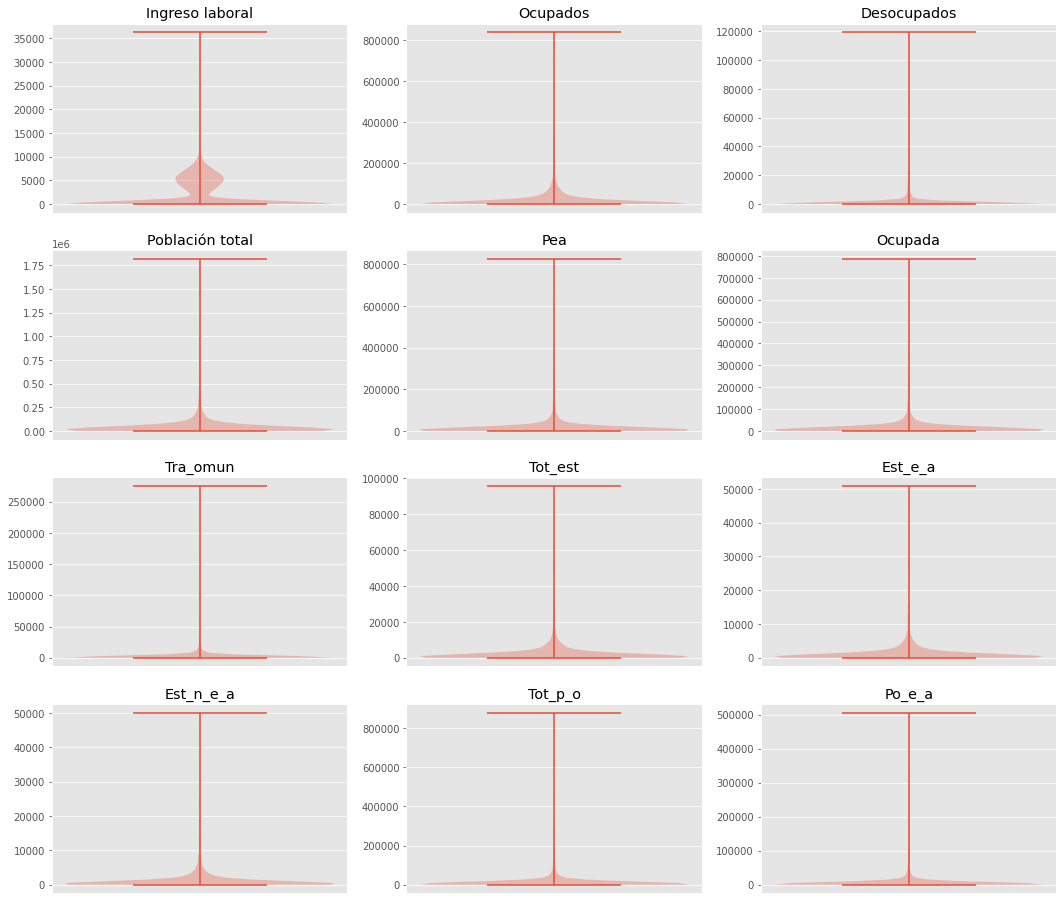

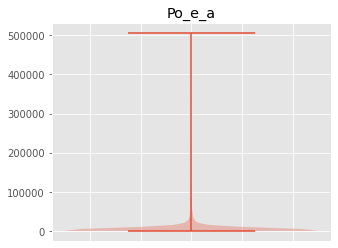

In [ ]:
pobCols = {"ing_lab": "Ingreso laboral", "pob": "Población total"}
pobKeys = pobCols.keys()
fig, axs = plt.subplots(4, 3, figsize=(18, 16))

for i, col in enumerate(pobData.columns[:-1]):
    ax = axs.flatten()[i]
    ax.violinplot(pobData[col])
    ax.set_title(col.capitalize() if col not in pobKeys else pobCols[col].capitalize())
    ax.get_xaxis().set_visible(False)

f1 = plt.figure(figsize=(5, 4))
plt.violinplot(pobData[col])
plt.title(col.capitalize() if col not in pobKeys else pobCols[col].capitalize());
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_xticklabels():
    xlabel_i.set_visible(False)
for tick in frame1.axes.get_xticklines():
    tick.set_visible(False)

En este caso los gráficos nuevamente muestran una gran variabilidad de resultados, soportado por los estadísticos arriba mostrados. Dados esos estadísticos se pudieron localizar algunos casos en los que existen valores negativos (notables en los mínimos) cuando no deben de existir. Estos valores se deben a que no hay datos históricos debido a la reciente creación del municipio, por tanto no nos sirven para este análisis y se eliminaron del conjunto de datos.

In [ ]:
def filterMoreEqualZero(data, cols):
    fData = data
    for col in cols:
      fData = fData[fData[col] >= 0]
    return fData

In [ ]:
shapeBeforeFilter = dataframe.shape[0]
dataframe = filterMoreEqualZero(dataframe, pobTypes)
print(f"Se eliminaron {shapeBeforeFilter - dataframe.shape[0]} filas con el filtro")

Se eliminaron 11 filas con el filtro


In [ ]:
df = dataframe.drop(['imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO'], axis=1)
generarEstadisticos(df)

,promedio,desviación estándar,mínimo,cuantil 10,cuantil 25,mediana,cuantil 75,cuantil 90,máximo,rango intercuartílico
pobtot,48683.422920,139201.812963,0.0,1535.4,4225.25,13273.5,34432.5000,92124.60,1827868.00,30207.2500
ing_lab,2034.476958,3040.292275,0.0,0.0,0.00,0.0,4373.3975,6529.58,36323.24,4373.3975
ocupados,18982.542822,56118.928537,0.0,0.0,0.00,0.0,15175.0000,48528.00,837926.00,15175.0000
desocupados,1364.139070,5951.696160,0.0,0.0,0.00,0.0,0.0000,1993.00,119425.00,0.0000
pob,52529.962887,148928.080254,0.0,1675.0,4458.50,14148.0,37554.5000,100023.50,1815100.00,33096.0000
pea,19164.959217,61117.218656,0.0,417.4,1247.00,4165.5,11079.2500,33434.50,825520.00,9832.2500
ocupada,18387.198206,58694.946860,0.0,396.1,1190.50,3943.0,10704.0000,32097.90,786218.00,9513.5000
tra_omun,2722.535481,12203.415701,0.0,15.0,66.00,317.5,1218.7500,4143.30,275199.00,1152.7500
tot_est,2552.897227,6849.599661,7.0,62.0,168.00,617.0,2028.5000,5806.70,95568.00,1860.5000
est_e_a,1376.611746,3596.539445,5.0,37.0,95.00,346.0,1120.5000,3076.10,50880.00,1025.5000


                  skew    kurtosis
ing_lab       1.927336    9.361522
ocupados      6.399808   56.098638
desocupados   8.584578  106.082240
pob           6.719951   56.328630
pea           7.079893   62.287746
ocupada       7.068418   61.984415
tra_omun     10.625079  154.334928
tot_est       6.983882   64.725074
est_e_a       6.833507   63.099720
est_n_e_a     7.411026   73.427160
tot_p_o       8.316627   86.265779
po_e_a        8.890925  105.550976
po_n_e_a      8.179029   80.531401


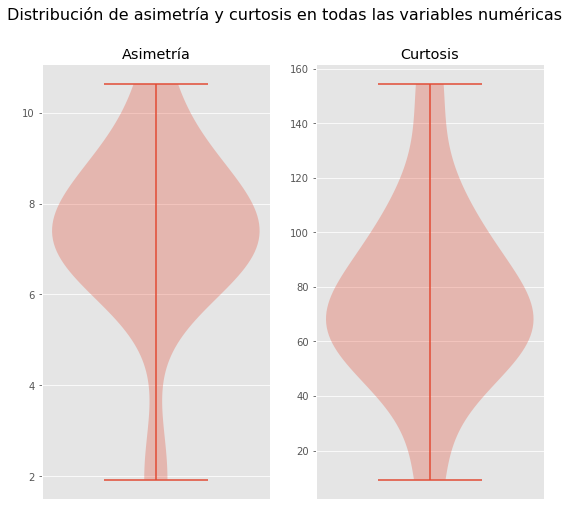

In [ ]:
pobData = df[pobTypes]
pobDistStatistics = distributionSkewAndKurtosis(pobData)
print(pobDistStatistics)

fig, axs = plt.subplots(1, 2, figsize=(9, 8))
fig.suptitle("Distribución de asimetría y curtosis en todas las variables numéricas", fontsize=16)
axs[0].violinplot(pobDistStatistics["skew"]);
axs[0].get_xaxis().set_visible(False)
axs[0].set_title("Asimetría");
axs[1].violinplot(pobDistStatistics["kurtosis"]);
axs[1].get_xaxis().set_visible(False)
axs[1].set_title("Curtosis");

Los resultados de la gráfica anterior muestran que la distribución de cada una de las columnas relacionadas con variables poblacionales y económicas para todos los municipios se encuentran alejadas de tener un comportamiento normal. En particular podemos ver que todas ellas tienen tanto la asemitría como la curtosis mayores a cero, lo cual indica que son de cola pesada cargadas hacia la derecha, como la que se muestra debajo.

Total de registros: 2452, municipios con más de 0 ocupados: 928


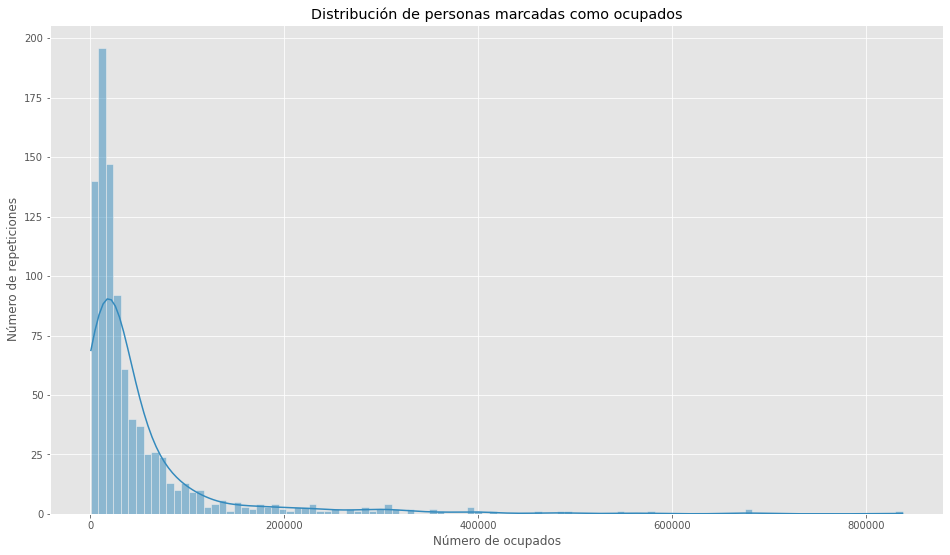

In [ ]:
print(f'Total de registros: {pobData.shape[0]}, municipios con más de 0 ocupados: {pobData[pobData["ocupados"] > 0]["ocupados"].count()}')

histpt = sns.histplot(x=pobData[pobData["ocupados"] > 0]["ocupados"], kde=True);
histpt.set_title("Distribución de personas marcadas como ocupados");
histpt.set_xlabel("Número de ocupados");
histpt.set_ylabel("Número de repeticiones");

### Análisis alimentos

In [ ]:
fTypes = {'comida_carta_corrida': "Comida corrida", 'pescados_mariscos': "Pescados y mariscos", 'pizzas_hamburguesas_hotdogs_pollos_rostizados': "Comida rápida",
           'tacos_tortas': "Tacos y tortas", 'otro_tipo_alimentos': "Otro"}
foodKeys = fTypes.keys()
foodTypes = ['comida_carta_corrida', 'antojitos', 'pescados_mariscos', 'pizzas_hamburguesas_hotdogs_pollos_rostizados', 'tacos_tortas',
       'autoservicio', 'otro_tipo_alimentos']
food = pd.DataFrame()
for fType in foodTypes:
    tmp = pd.DataFrame(dataframe[fType].values, columns=["Quantity"])
    tmp["Type"] = fType.capitalize() if fType not in foodKeys else fTypes[fType].capitalize()
    food = food.append(tmp)

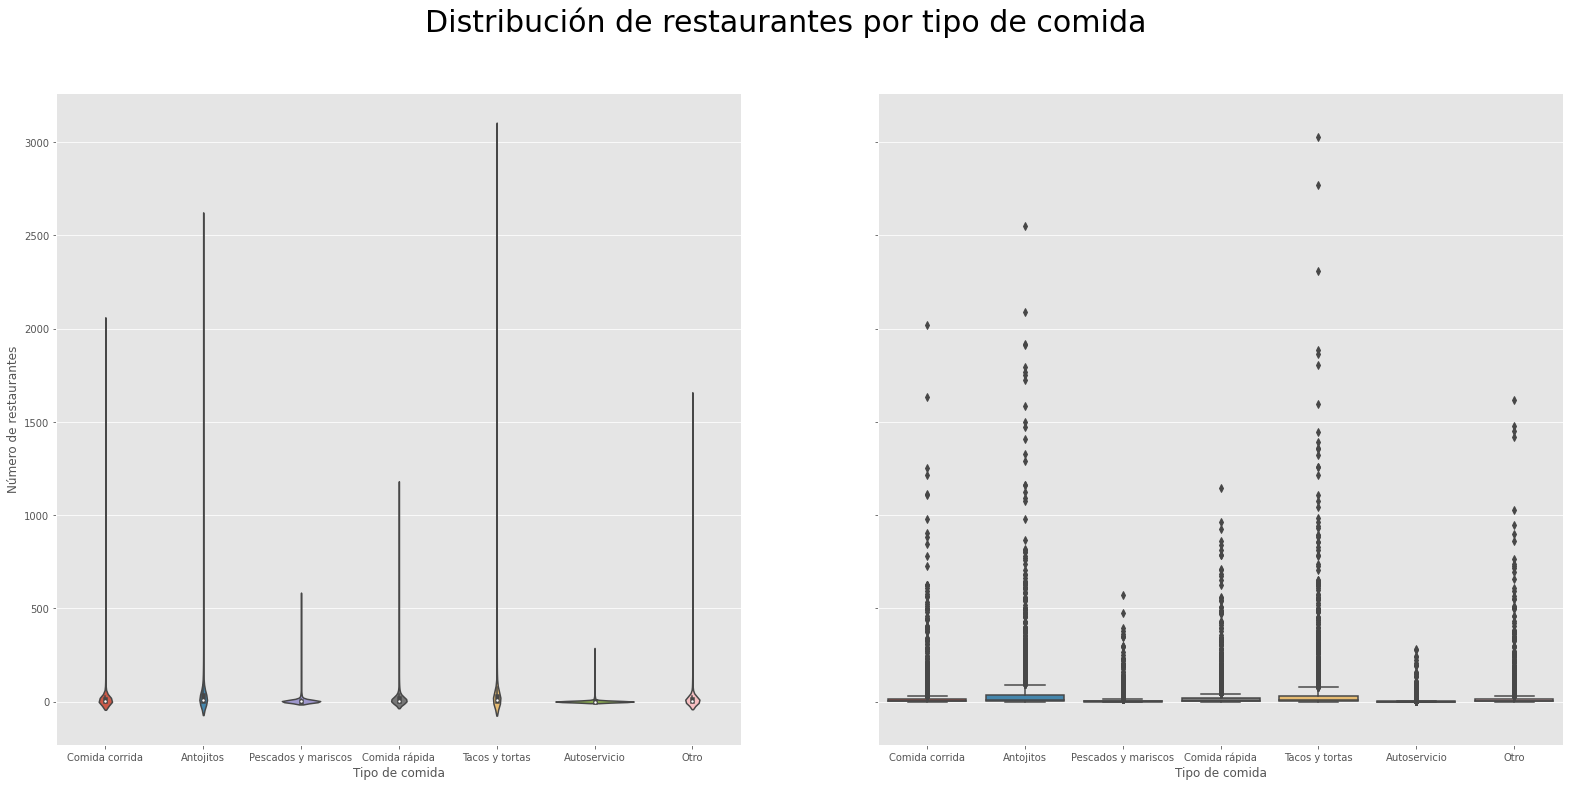

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9*3, 4*3), sharey=True)

fig.suptitle("Distribución de restaurantes por tipo de comida", fontsize=30)
violin = sns.violinplot(ax=axs[0], x="Type", y="Quantity", data=food);
violin.set(xlabel='Tipo de comida', ylabel='Número de restaurantes');
boxpt = sns.boxplot(ax=axs[1], x="Type", y="Quantity", data=food);
boxpt.set(xlabel='Tipo de comida', ylabel=None);

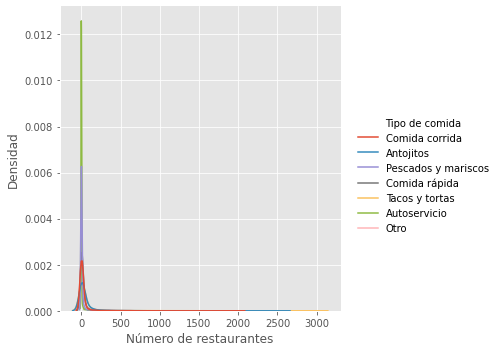

In [ ]:
"""sns.kdeplot(
   data=food, x="Quantity", hue="Type",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0
);"""

kdept = sns.displot(data=food, x="Quantity", kind="kde", hue="Type");
kdept.set(xlabel='Número de restaurantes', ylabel="Densidad");
kdept._legend.set_title("Tipo de comida");

In [ ]:
generarEstadisticos(df[foodTypes])

,promedio,desviación estándar,mínimo,cuantil 10,cuantil 25,mediana,cuantil 75,cuantil 90,máximo,rango intercuartílico
comida_carta_corrida,26.641109,103.325963,0.0,0.0,1.0,3.0,13.0,43.0,2018.0,12.0
antojitos,56.418842,171.260764,0.0,0.0,2.0,10.0,38.0,119.9,2552.0,36.0
pescados_mariscos,9.944943,35.574859,0.0,0.0,0.0,1.0,5.0,18.0,570.0,5.0
pizzas_hamburguesas_hotdogs_pollos_rostizados,27.763458,83.601674,0.0,0.0,1.0,6.0,18.0,55.9,1147.0,17.0
tacos_tortas,55.171697,178.359038,0.0,0.0,2.0,10.0,33.0,108.0,3030.0,31.0
autoservicio,4.056281,19.201207,0.0,0.0,0.0,0.0,1.0,4.9,280.0,1.0
otro_tipo_alimentos,25.517945,96.538537,0.0,0.0,1.0,4.0,13.0,44.0,1619.0,12.0


En este caso, a pesar de que existen bastantes valores atípicos, y que las distribuciones de los valores están centradas en valores chicos, aquellos con valores grandes no son precisamente datos fuera de lugar, sino de municipios con grandes urbes como las alcaldías de la CDMX. Por tanto no se requiere elmininarlas, puesto que son importantes aunque muestran la realidad de nuestro país, donde la mayoría de los municipios cuentan con pocos restaurantes, sin importar el tipo de comida. Aunado a ello, en el boxplot (así como en los estadísticos), no hay valores negativos, es decir, todos son válidos. Más adelante se tratará de identificar si realmente son los munipios con mayor número de pobladores aquellos que tiene mayor número de restaurantes, y si lo tienen en todos los tipos de restaurantes.

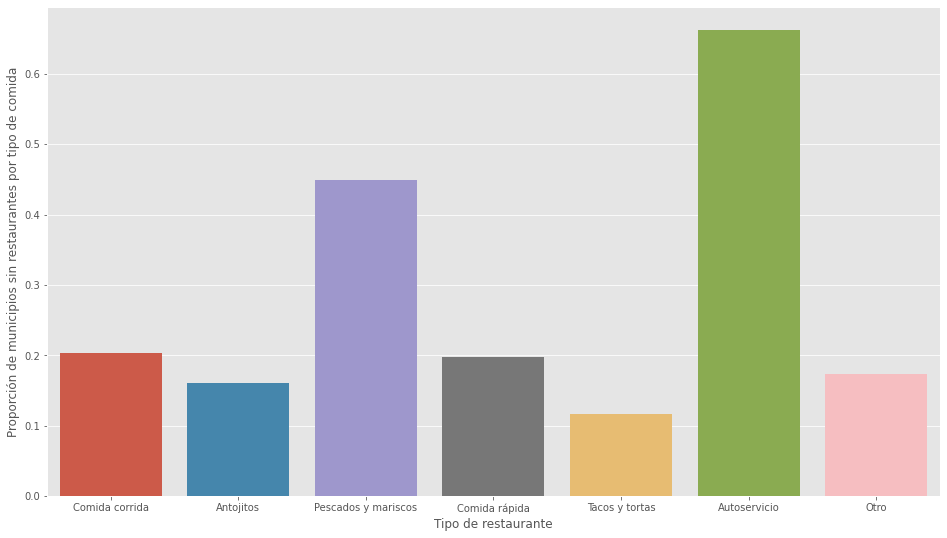

In [ ]:
onlyFood = dataframe[foodTypes]
zeroRestaurants = (onlyFood == 0).sum() / onlyFood.count()
bpt = sns.barplot(x=[ind.capitalize() if ind not in fTypes.keys() else fTypes[ind].capitalize() for ind in zeroRestaurants.index], y=zeroRestaurants);
bpt.set_xlabel("Tipo de restaurante");
bpt.set_ylabel("Proporción de municipios sin restaurantes por tipo de comida");

Habría que analizar si todos estos valores en cero son realmente por la ausencia de restaurantes de ese tipo, o no fueron contados de manera correcta. Este análisis se tendría que realizar a fondo con los creadores de la base de datos de donde se tomaron estos valores.

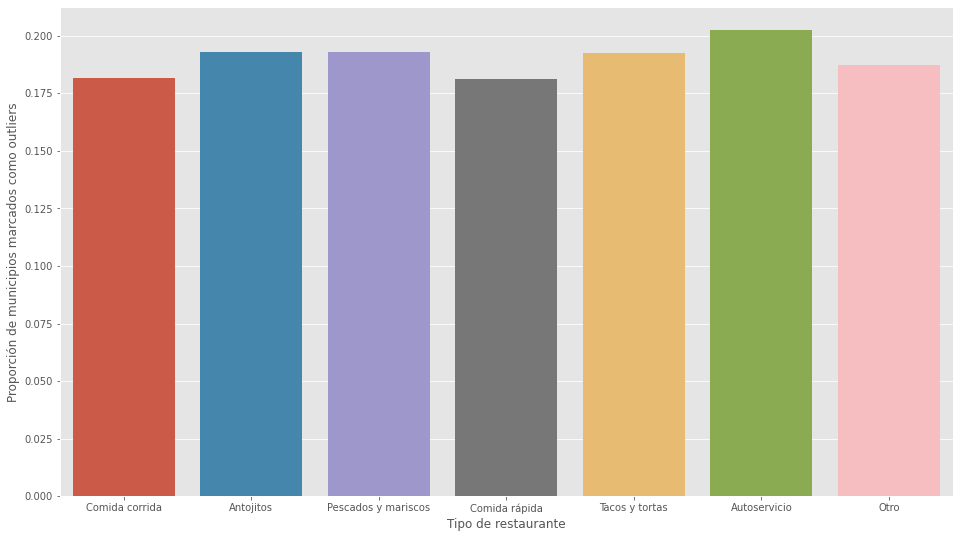

In [ ]:
outlier = onlyFood.quantile(0.75)*1.5
foodOutliers = (onlyFood > outlier).sum() / onlyFood.count()
bpt = sns.barplot(x=[ind.capitalize() if ind not in fTypes.keys() else fTypes[ind].capitalize() for ind in foodOutliers.index], y=foodOutliers);
bpt.set_xlabel("Tipo de restaurante");
bpt.set_ylabel("Proporción de municipios marcados como outliers");

Los resultados de arriba muestran la proporción de restaurantes considerados como outliers (mayores a 1.5 veces el tercer curtil) de cada tipo de comida. Esta gráfica refuerza la idea de que la distribución de datos es bastante desigual, observación soportada por los valores de desviación estándar y anteriores estadísticos ya mostrados. Es decir, el 80% de los datos tienen un cierto comportamiento, y el otro 20% uno muy distinto, los cuales modifican ciertos estadísticos como el promedio, pero que resultan de vital importancia y que dejan en claro que existe una dseiguldad en la distribución de los restaurantes en el país.

## **3. Exploración de Variables Categóricas y Análisis Multivariable**

En este Postwork vamos a explorar las distribuciones de las variables categóricas de nuestro dataset. En el postwork pasado exploramos las variables numéricas y ya deberías de tener una idea general bastante buena de cómo están organizadas. Ahora es momento de hacer análisis de variables categóricas y análisis multivariable. 

Realiza los siguientes pasos si tiene sentido aplicarlos a tu conjunto de datos:

1. Si ya tienes gráficas realizadas en Postworks anteriores, agrega títulos, anotaciones y leyendas donde sea necesario. También cambia el tamaño de las gráficas donde tenga sentido hacerlo.
2. Identifica todas las variables categóricas en tu dataset.
3. Utiliza gráficas de barras para explorar la distribución de tus variables categóricas.
4. Planea tu análisis multivariable: ¿qué combinaciones de variables categóricas podrían darme información útil acerca de la distribución de mis datos? ¿qué combinaciones de una variable numérica con una variable categórica podrían ser interesantes?
5. Utiliza tablas de contingencia y múltiples gráficas en la misma figure para explorar combinaciones de variables categóricas.
6. Utiliza boxplots y violinplots para explorar combinaciones de variables numéricas con variables categóricas.
7. De preferencia ve registrando por escrito (ahí mismo en tu Notebook) todos tus hallazgos. Describe qué vas descubriendo y qué podría significar.

## **4. Correlaciones y Regresión Linear Simple**

En este Postwork vamos a hacer análisis bivariado de nuestras variables numéricas. Si tu dataset sólo tiene variables categóricas o datos no estructurados (texto libre), entonces puedes pedirle a tu experta que te comparta algún dataset con el que puedas realizar estos ejercicios.

Utilizando tu dataset, realiza las siguientes actividades:

1. Identifica cuáles son las variables numéricas en tu dataset.
2. Asegúrate de que tengan el tipo de dato correcto y que no haya NaNs por ahí escondidos.
3. Genera una matriz de correlaciones y un pairplot para visualizar de manera general las relaciones entre tus variables numéricas.
4. Utilizando gráficas de dispersión y tus medidas de locación y dispersión, identifica dónde hay valores atípicos y decide qué hacer con ellos.
5. Revisa si tu revisión de valores atípicos cambió de alguna manera las relaciones existentes.
6. Donde consideres necesario, entrena modelos de Regresión Lineal con un o más pares de variables. Incluso si no te parece que realizar predicciones entre pares de variables tiene sentido para tu proyecto, prueba realizar un par de regresiones para que practiques el procedimiento.

In [18]:
# Creamos una copia de nuestro dataframe
df_pw4 = dataframe
df_pw4.head()

,imun,ent,nom_ent,mun,nom_mun,pobtot,ing_lab,ocupados,desocupados,pob,pea,ocupada,tra_omun,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,pizzas_hamburguesas_hotdogs_pollos_rostizados,tacos_tortas,autoservicio,otro_tipo_alimentos,CVEGEO
2,1001,1,Aguascalientes,1.0,Aguascalientes,877190.0,7676.46,300564.0,24836.0,974529.0,382550.0,367528.0,9344.0,46426,23283,23142,334896,153478,181418,402.0,2092.0,192.0,506.0,1046.0,96.0,338.0,01001
3,1002,1,Aguascalientes,2.0,Asientos,46464.0,5863.52,8138.0,693.0,51383.0,13914.0,13108.0,3585.0,989,549,440,5165,2023,3142,6.0,44.0,3.0,11.0,37.0,0.0,5.0,01002
4,1003,1,Aguascalientes,3.0,Calvillo,56048.0,5784.97,14757.0,199.0,61389.0,20099.0,19352.0,298.0,3280,1750,1529,14944,7370,7573,14.0,122.0,4.0,26.0,58.0,2.0,4.0,01003
5,1004,1,Aguascalientes,4.0,Cosío,15577.0,6096.05,3801.0,87.0,17076.0,4869.0,4627.0,1579.0,1000,591,408,4538,3172,1366,0.0,27.0,3.0,2.0,10.0,0.0,2.0,01004
6,1005,1,Aguascalientes,5.0,Jesús María,120405.0,6262.18,37341.0,3187.0,132340.0,51020.0,49795.0,19699.0,6377,3402,2975,63320,22688,40631,28.0,207.0,24.0,57.0,154.0,3.0,28.0,01005


Se identifican diversas variables numéricas dentro del dataset. Procedemos a seleccionar ciertas columnas y observar si existe una correlación entre las mismas.

### Población y tipo de restaurantes por entidad

Tomamos como punto de partida, la variable de población junto con las variables que representan a cada tipo de restaurante. Para un mejor análisis, realizamos la matriz de correlación dependiendo la entidad que seleccionemos. En este caso tomamos 3: Ciudad de México, Veracruz y Oaxaca

#### **Ciudad de México**

In [19]:
# Tomamos la entidad de interés
ent = 9

filtro = df_pw4['ent'] == ent

d1 = df_pw4[filtro]

#Enlistamos las columnas de interés para obtener la matriz de correlación
lista = ['pob','comida_carta_corrida','antojitos','pescados_mariscos','pizzas_hamburguesas_hotdogs_pollos_rostizados','tacos_tortas','autoservicio','otro_tipo_alimentos']

d1 = d1[lista]

diccionario = ['Población','A','B','C','D','E','F','G']

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

d1.columns = diccionario

# Verificamos si existen NaN's en las columnas
na = d1.isna().sum().sum()

print(f'Número de NaN en el dataframe: {na}')

d1.head()

Número de NaN en el dataframe: 0


,Población,A,B,C,D,E,F,G
280,407280.0,388.0,503.0,74.0,153.0,544.0,68.0,457.0
281,620486.0,569.0,491.0,99.0,249.0,633.0,99.0,433.0
282,199926.0,202.0,182.0,29.0,80.0,201.0,49.0,127.0
283,1173555.0,627.0,1328.0,185.0,510.0,1322.0,96.0,1029.0
284,393275.0,262.0,459.0,81.0,153.0,426.0,20.0,371.0


In [20]:
d1_corr = d1.corr()
d1_corr

,Población,A,B,C,D,E,F,G
Población,1.000000,0.213604,0.922596,0.886071,0.971898,0.840863,0.500581,0.893759
A,0.213604,1.000000,0.277152,0.528883,0.380917,0.643397,0.919361,0.478027
B,0.922596,0.277152,1.000000,0.925712,0.926501,0.903801,0.493033,0.967817
C,0.886071,0.528883,0.925712,1.000000,0.935547,0.971285,0.705142,0.968114
D,0.971898,0.380917,0.926501,0.935547,1.000000,0.916101,0.619837,0.942501
E,0.840863,0.643397,0.903801,0.971285,0.916101,1.000000,0.794503,0.969787
F,0.500581,0.919361,0.493033,0.705142,0.619837,0.794503,1.000000,0.665651
G,0.893759,0.478027,0.967817,0.968114,0.942501,0.969787,0.665651,1.000000


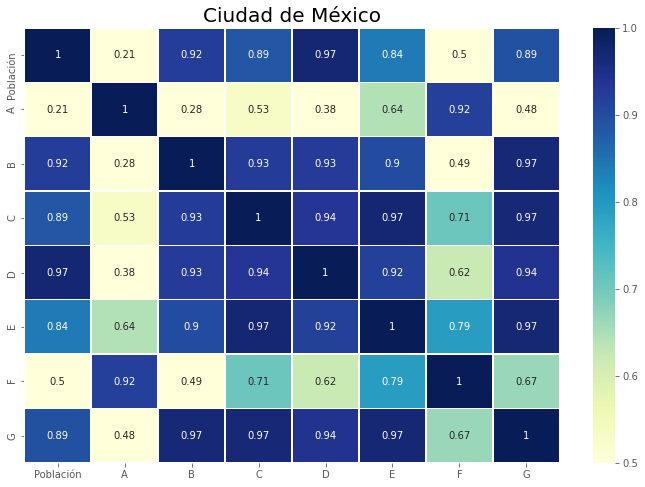

In [23]:
plt.figure(figsize=(12, 8))
ax = sns.heatmap(d1_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);
ax.set_title('Ciudad de México',fontsize = 20);

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

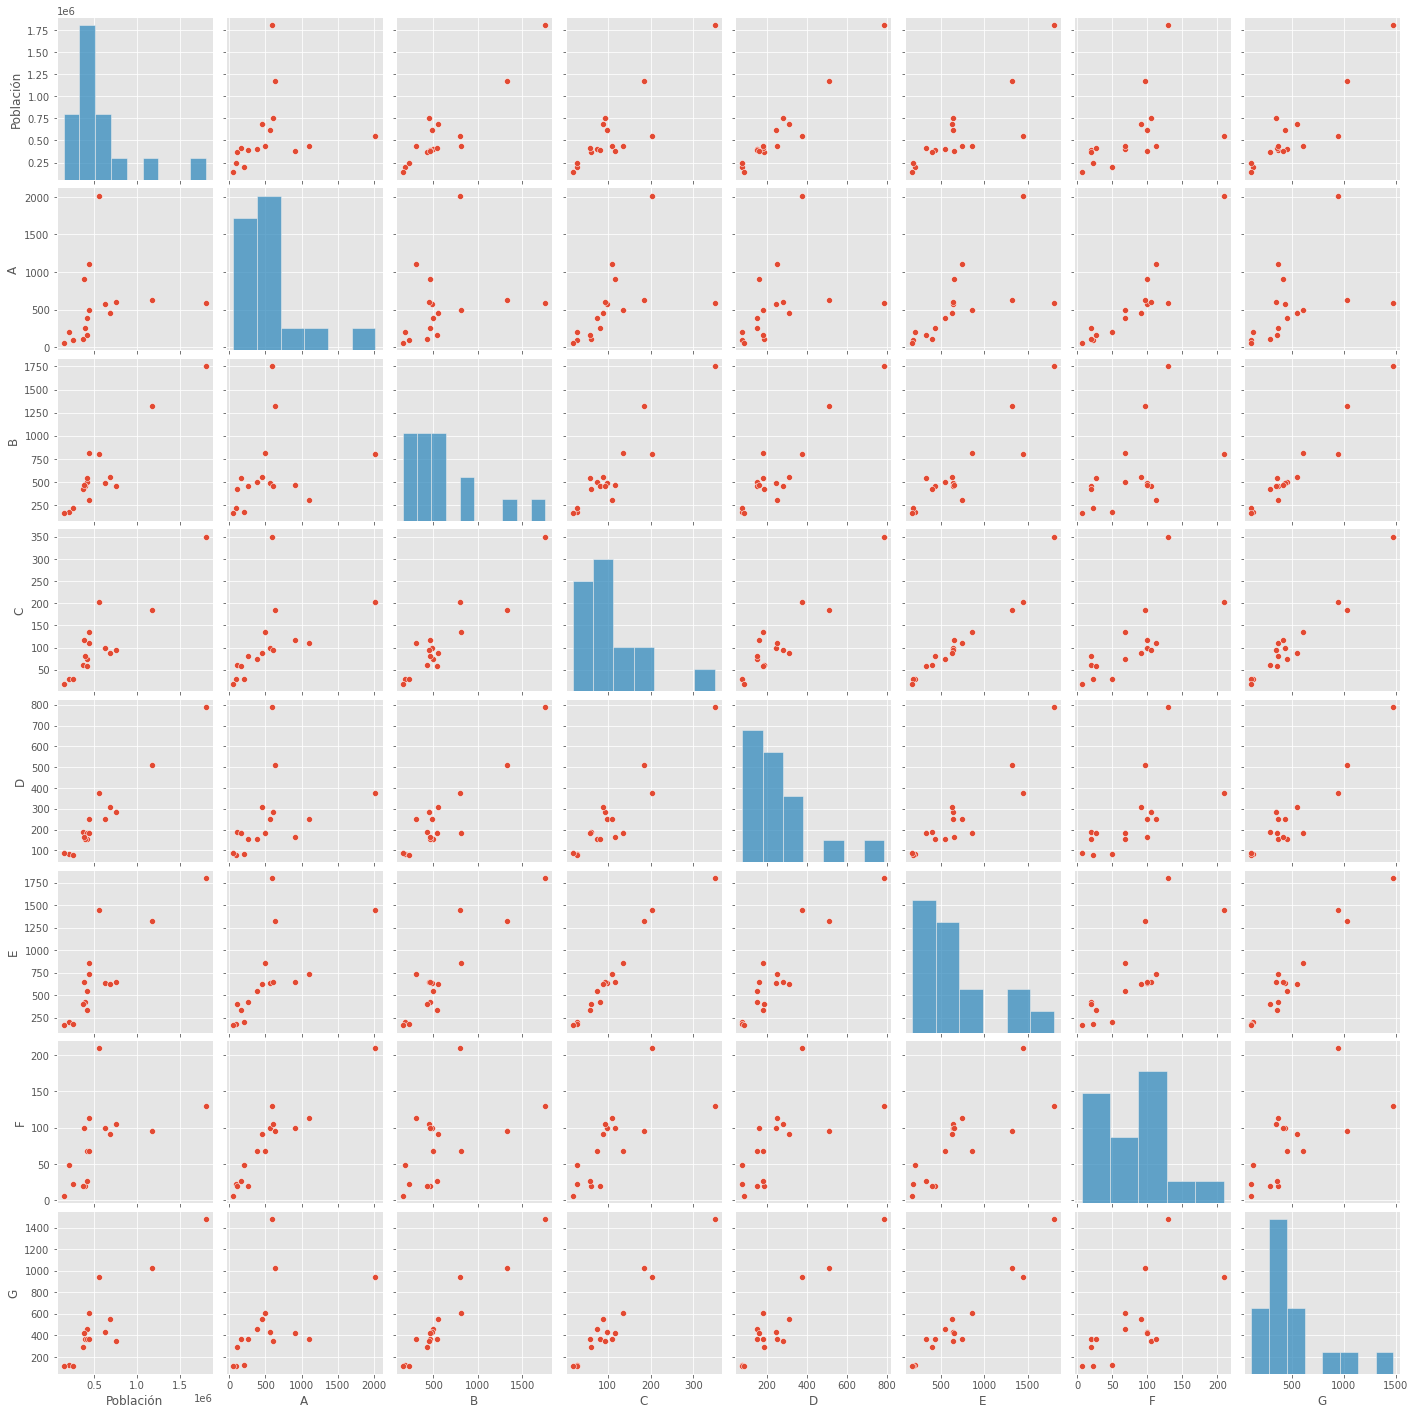

In [ ]:
sns.pairplot(d1);

#### **Veracruz**

In [24]:
# Tomamos la entidad de interés
ent = 30

filtro = df_pw4['ent'] == ent

d2 = df_pw4[filtro]

#Enlistamos las columnas de interés para obtener la matriz de correlación
lista = ['pob','comida_carta_corrida','antojitos','pescados_mariscos','pizzas_hamburguesas_hotdogs_pollos_rostizados','tacos_tortas','autoservicio','otro_tipo_alimentos']

d2 = d2[lista]

diccionario = ['Población','A','B','C','D','E','F','G']

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

d2.columns = diccionario

# Verificamos si existen NaN's en las columnas
na = d2.isna().sum().sum()

print(f'Número de NaN en el dataframe: {na}')

d2.head()

Número de NaN en el dataframe: 0


,Población,A,B,C,D,E,F,G
2118,9168.0,4.0,10.0,0.0,2.0,2.0,1.0,8.0
2119,3360.0,1.0,2.0,0.0,2.0,7.0,0.0,4.0
2120,91514.0,58.0,180.0,39.0,60.0,73.0,6.0,22.0
2121,46155.0,4.0,41.0,4.0,11.0,13.0,0.0,5.0
2122,5728.0,1.0,4.0,2.0,0.0,5.0,0.0,1.0


In [25]:
d2_corr = d2.corr()
d2_corr

,Población,A,B,C,D,E,F,G
Población,1.000000,0.920286,0.910292,0.885313,0.946405,0.957508,0.877435,0.834230
A,0.920286,1.000000,0.843721,0.835000,0.946307,0.933872,0.899695,0.926310
B,0.910292,0.843721,1.000000,0.929870,0.868617,0.923591,0.883229,0.726379
C,0.885313,0.835000,0.929870,1.000000,0.851523,0.885166,0.886763,0.683176
D,0.946405,0.946307,0.868617,0.851523,1.000000,0.939524,0.897752,0.920644
E,0.957508,0.933872,0.923591,0.885166,0.939524,1.000000,0.872901,0.836520
F,0.877435,0.899695,0.883229,0.886763,0.897752,0.872901,1.000000,0.818162
G,0.834230,0.926310,0.726379,0.683176,0.920644,0.836520,0.818162,1.000000


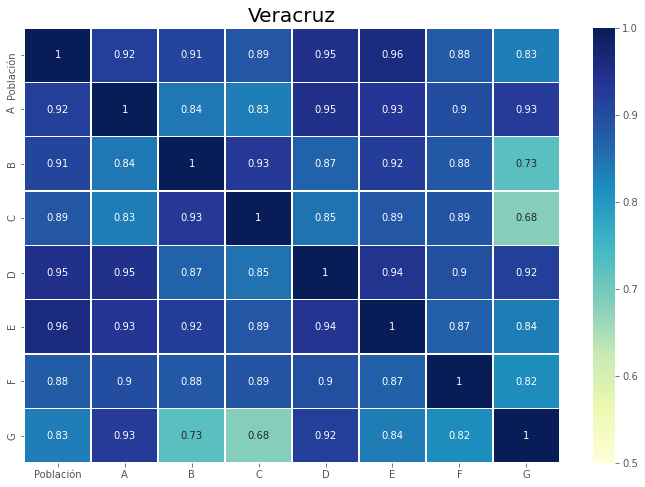

In [26]:
plt.figure(figsize=(12, 8))
ax = sns.heatmap(d2_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);
ax.set_title('Veracruz',fontsize = 20);

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

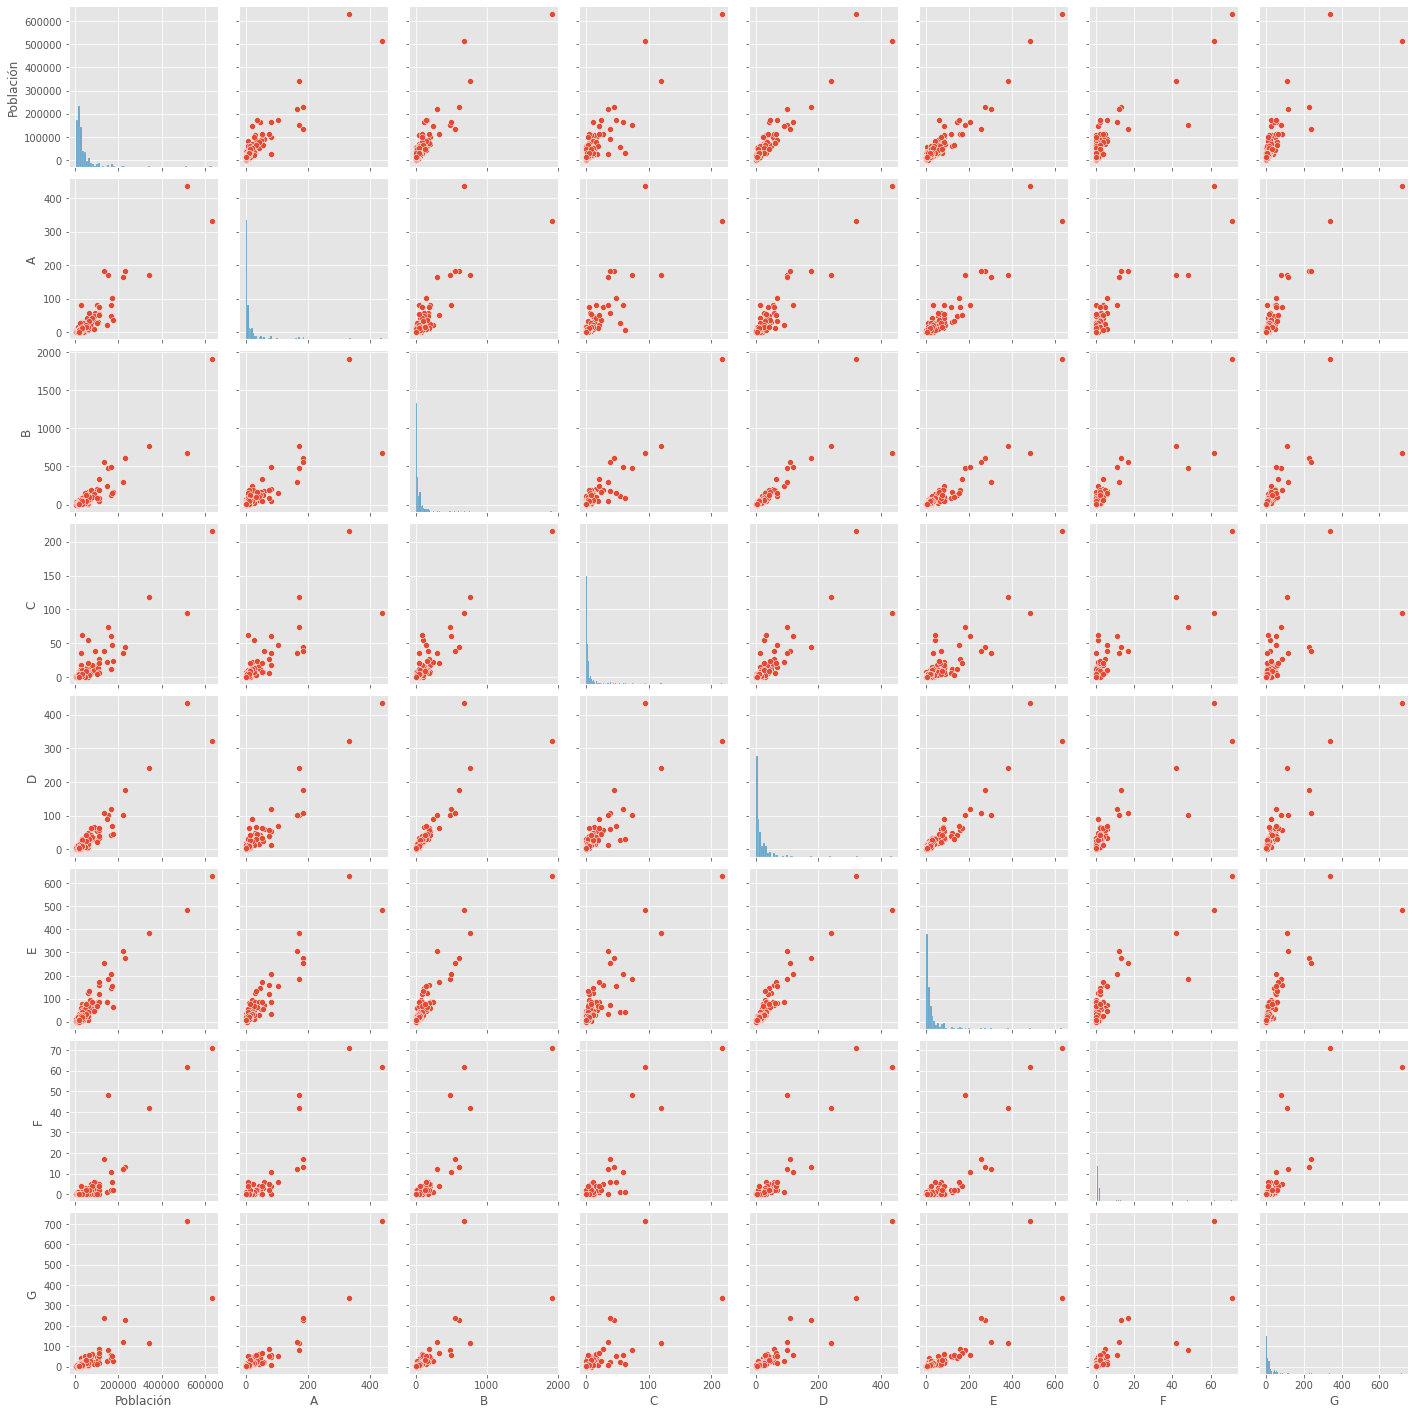

In [ ]:
sns.pairplot(d2);

#### **Oaxaca**

In [27]:
# Tomamos la entidad de interés
ent = 20

filtro = df_pw4['ent'] == ent

d3 = df_pw4[filtro]

#Enlistamos las columnas de interés para obtener la matriz de correlación
lista = ['pob','comida_carta_corrida','antojitos','pescados_mariscos','pizzas_hamburguesas_hotdogs_pollos_rostizados','tacos_tortas','autoservicio','otro_tipo_alimentos']

d3 = d3[lista]

diccionario = ['Población','A','B','C','D','E','F','G']

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

d3.columns = diccionario

# Verificamos si existen NaN's en las columnas
na = d3.isna().sum().sum()

print(f'Número de NaN en el dataframe: {na}')

d3.head()

Número de NaN en el dataframe: 0


,Población,A,B,C,D,E,F,G
1024,1019.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1025,47807.0,10.0,68.0,3.0,37.0,73.0,0.0,26.0
1026,2172.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1027,1035.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0
1028,15904.0,11.0,26.0,1.0,4.0,7.0,0.0,18.0


In [28]:
d3_corr = d3.corr()
d3_corr

,Población,A,B,C,D,E,F,G
Población,1.000000,0.812165,0.905482,0.737236,0.957470,0.939217,0.811226,0.900453
A,0.812165,1.000000,0.719760,0.740830,0.883499,0.931666,0.950039,0.868240
B,0.905482,0.719760,1.000000,0.811332,0.881987,0.859588,0.746470,0.917148
C,0.737236,0.740830,0.811332,1.000000,0.740276,0.765319,0.699083,0.823135
D,0.957470,0.883499,0.881987,0.740276,1.000000,0.975218,0.889949,0.936693
E,0.939217,0.931666,0.859588,0.765319,0.975218,1.000000,0.922274,0.929312
F,0.811226,0.950039,0.746470,0.699083,0.889949,0.922274,1.000000,0.894544
G,0.900453,0.868240,0.917148,0.823135,0.936693,0.929312,0.894544,1.000000


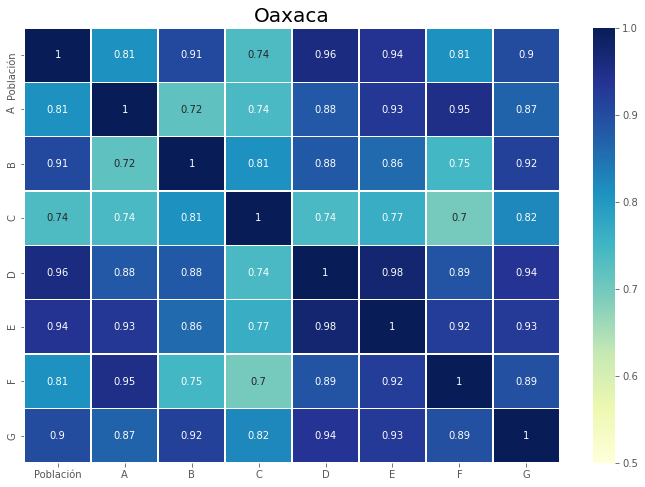

In [29]:
plt.figure(figsize=(12, 8))
ax = sns.heatmap(d3_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);
ax.set_title('Oaxaca',fontsize = 20);

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

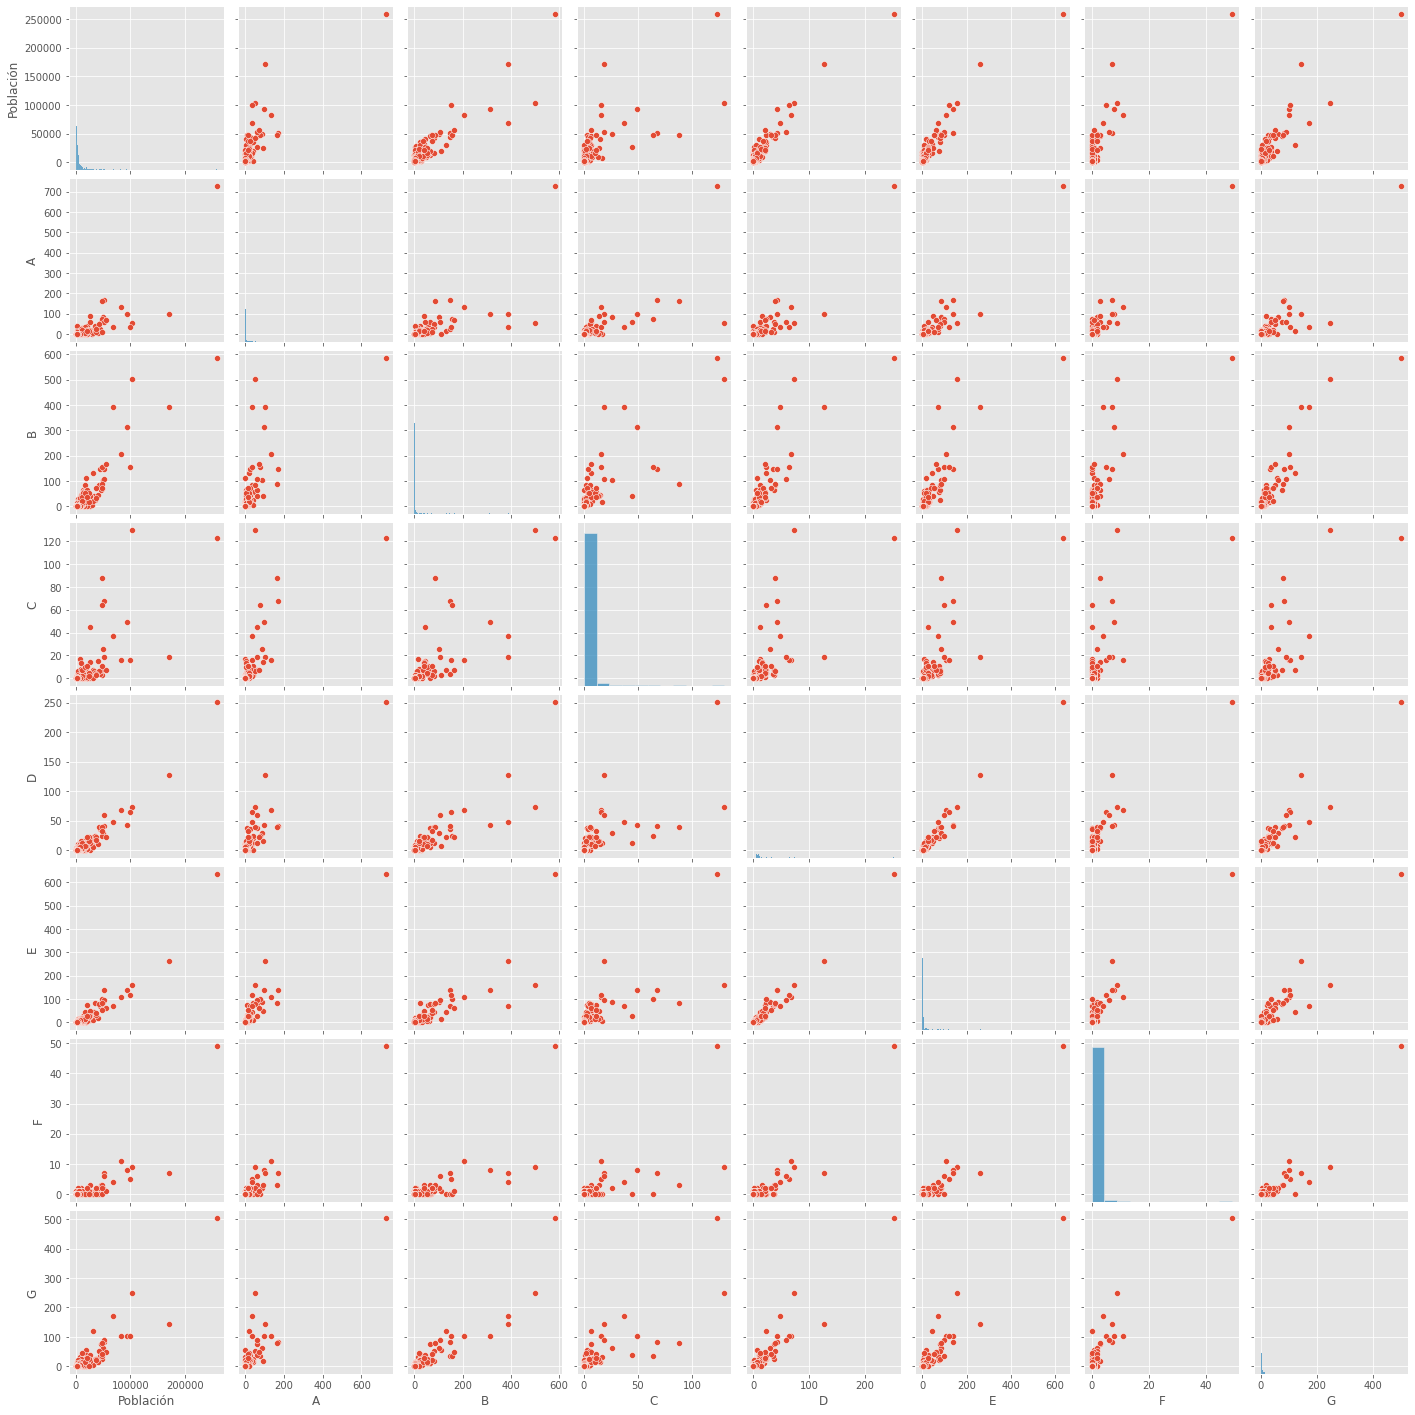

In [ ]:
sns.pairplot(d3);

#### **Comparativa**

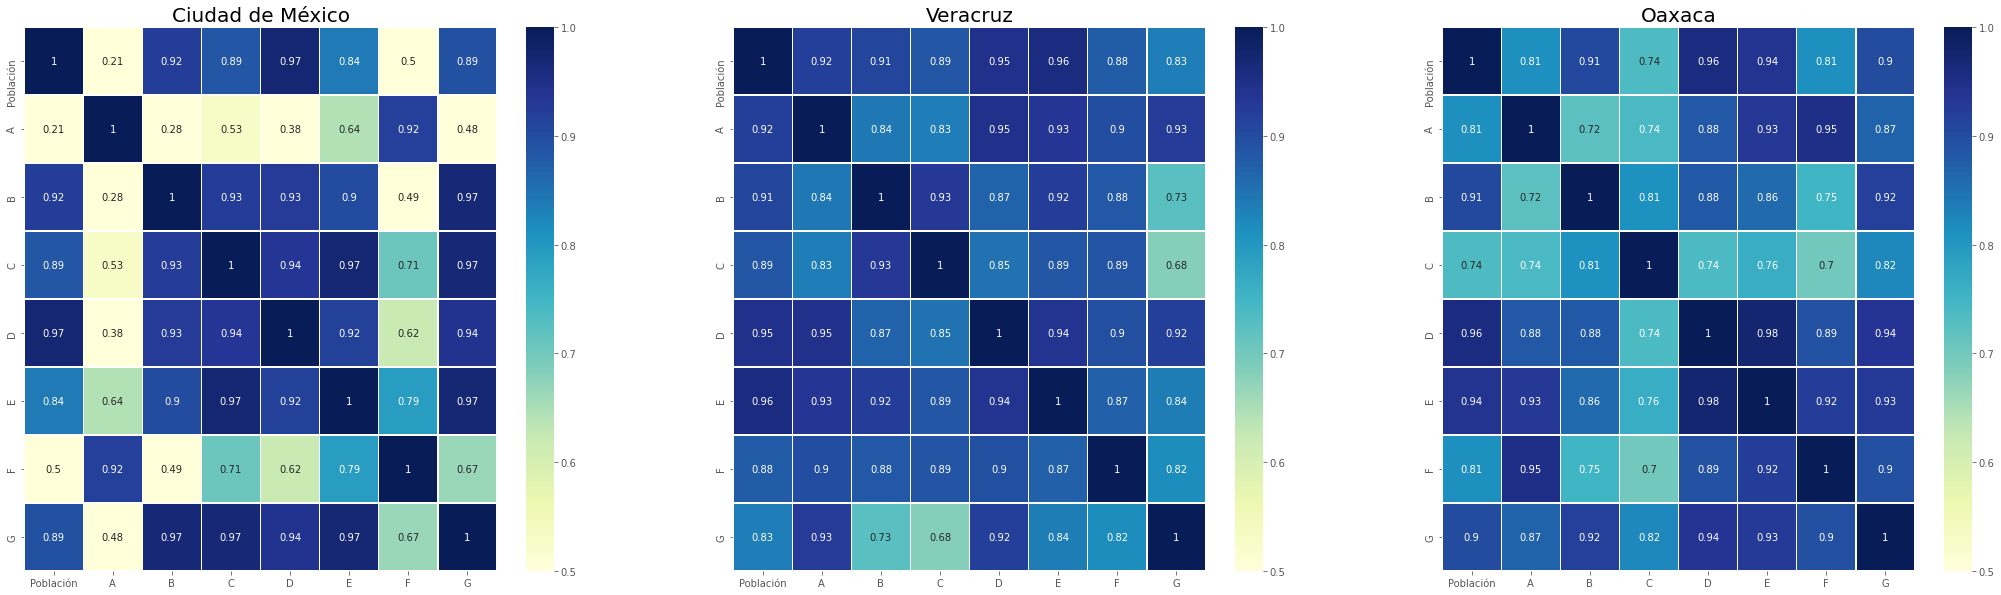

In [ ]:
fig,ax =plt.subplots(1,3, figsize=(36, 10))

sns.heatmap(d1_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5,ax=ax[0]);
sns.heatmap(d2_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5,ax=ax[1]);
sns.heatmap(d3_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5,ax=ax[2]);

ax[0].set_title('Ciudad de México',fontsize = 20);
ax[1].set_title('Veracruz',fontsize = 20);
ax[2].set_title('Oaxaca',fontsize = 20);

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

Nuestra comparativa nos muestra resultados interesantes. Para los establecimientos con comida corrida, nos indica una alta correlación con los de autoservicio. Se puede observar también que las correlaciones entre población y los distintos tipos de restaurante cambian entre entidades, no obstante, es importante considerar que existe una posibilidad que esto se deba a la diferencia de municipios en otras entidades comparado con los de la Ciudad de México.

### Población, ingreso laboral, ocupados y desocupados

In [ ]:
lista = ['pobtot','ing_lab','ocupados','desocupados']

d4 = df_pw4[lista]

filtro = d4['ing_lab'] != 0
d4 = d4[filtro]

# Verificamos si existen NaN's en las columnas
na = d4.isna().sum().sum()

print(f'Número de NaN en el dataframe: {na}')

d4.head()

Número de NaN en el dataframe: 0


,pobtot,ing_lab,ocupados,desocupados
2,877190.0,7676.46,300564.0,24836.0
3,46464.0,5863.52,8138.0,693.0
4,56048.0,5784.97,14757.0,199.0
5,15577.0,6096.05,3801.0,87.0
6,120405.0,6262.18,37341.0,3187.0


In [ ]:
d4_corr = d4.corr()
d4_corr

,pobtot,ing_lab,ocupados,desocupados
pobtot,1.000000,0.287626,0.915010,0.812092
ing_lab,0.287626,1.000000,0.278456,0.224929
ocupados,0.915010,0.278456,1.000000,0.764730
desocupados,0.812092,0.224929,0.764730,1.000000


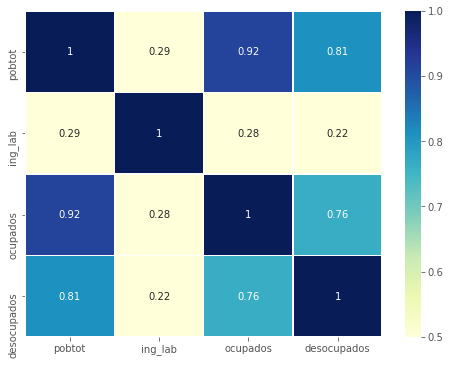

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(d4_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);

La matriz de correlación únicamente nos muestra que existe una fuerte correlación entre la población y el númerom de ocupados, no nos proporciona mucha información.

### Regresión lineal

Se toma como final la de población y tipos de restaurantes para la regresión lineal. En nuestro caso, no existen como tal valores atípicos para el análisis realizado en las matrices de correlación, ya que los valores que toman las variables contienen datos que son de interés.

In [30]:
d5 = df_pw4

#Enlistamos las columnas de interés para obtener la matriz de correlación
lista = ['pobtot','ing_lab','comida_carta_corrida','antojitos','pescados_mariscos','pizzas_hamburguesas_hotdogs_pollos_rostizados','tacos_tortas','autoservicio','otro_tipo_alimentos']

d5 = d5[lista]

filtro = d5['ing_lab'] != 0

d5 = d5[filtro]

d5['total_restaurantes'] = d5[lista[2:]].sum(axis = 1)

d5 = d5.melt(id_vars=['pobtot','ing_lab','total_restaurantes'])

d5.head()

,pobtot,ing_lab,total_restaurantes,variable,value
0,877190.0,7676.46,4672.0,comida_carta_corrida,402.0
1,46464.0,5863.52,106.0,comida_carta_corrida,6.0
2,56048.0,5784.97,230.0,comida_carta_corrida,14.0
3,15577.0,6096.05,44.0,comida_carta_corrida,0.0
4,120405.0,6262.18,501.0,comida_carta_corrida,28.0


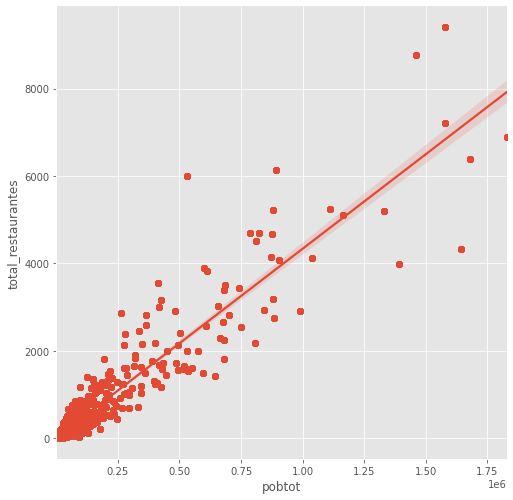

In [59]:
sns.lmplot(x='pobtot',y='total_restaurantes',data = d5,height = 7);

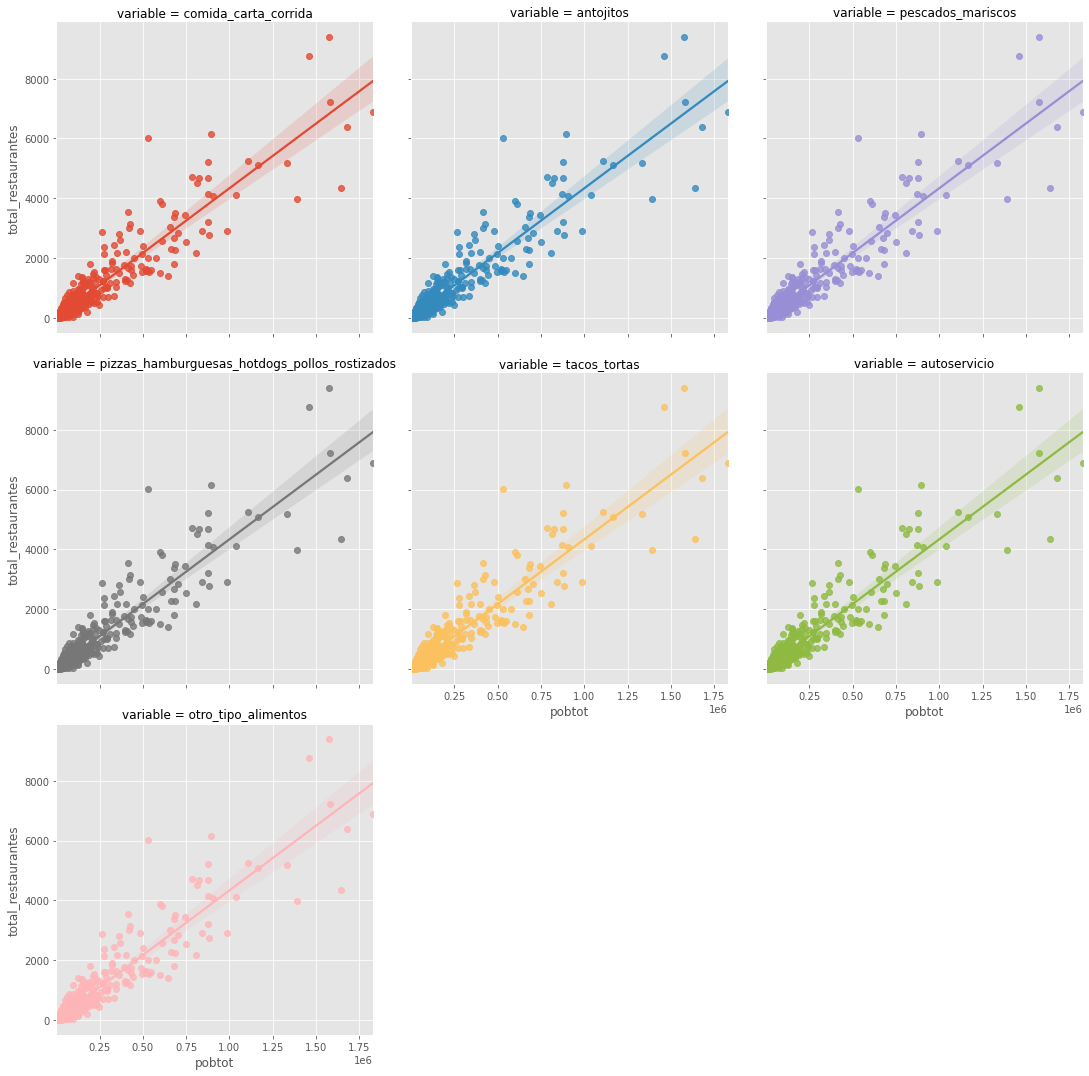

In [41]:
sns.lmplot(x='pobtot',y='total_restaurantes',data = d5,hue = 'variable',col='variable',col_wrap=3);

El resultado mostrado, corresponde a la regresión lineal comparando la población total y el total de restaurantes. Se observa que la regresión lineal muestra resultados correctos, esto se verifica más adelante en el PostWork 5, donde se muestra más detalladamente esta regresión linear.

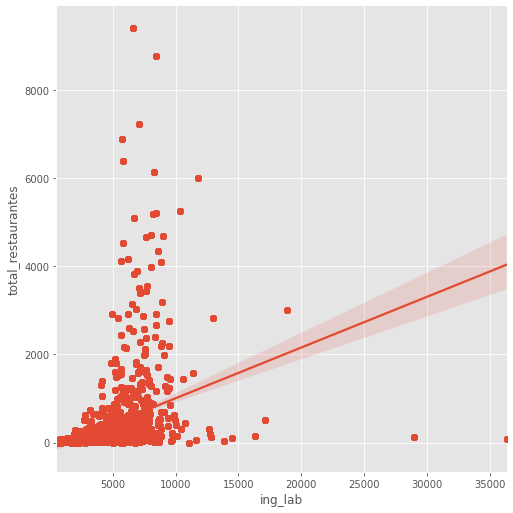

In [60]:
sns.lmplot(x='ing_lab',y='total_restaurantes',data = d5,height = 7);

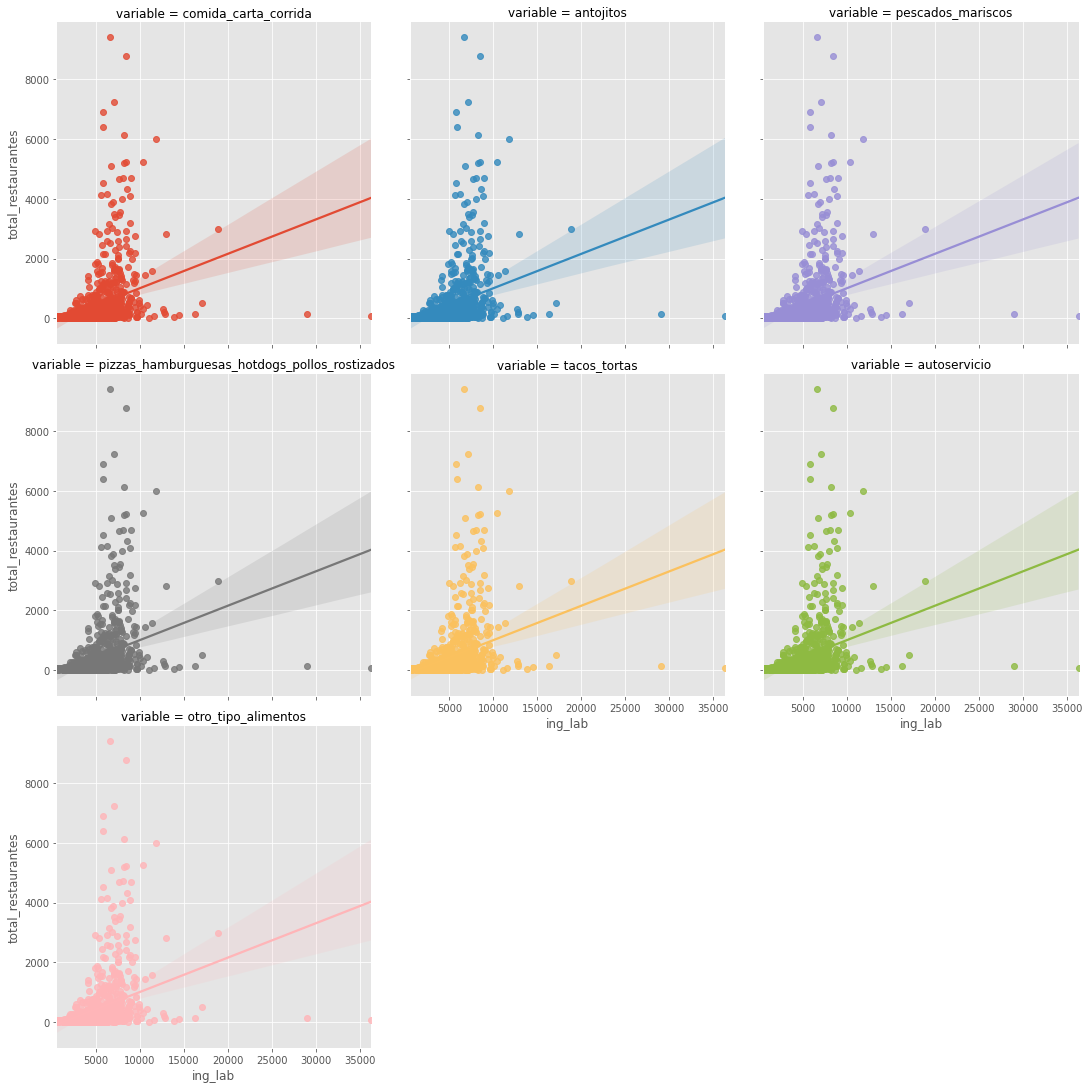

In [51]:
sns.lmplot(x='ing_lab',y='total_restaurantes',data = d5,hue = 'variable',col='variable',col_wrap=3);

El resultado mostrado, corresponde a la regresión lineal comparando el ingreso laboral y el total de restaurantes. Se observa que la regresión lineal muestra un resultado, que realmente no podemos asumir que sea correcto, esto debido a que realmente no hay ninguna correlación entre las variables.

## **5. Distribuciones muestrales y técnicas de evaluación de modelos**

En este Postwork vamos a analizar la incertidumbre y los sesgos que existen en las medidas de locación y dispersión de nuestras variables numéricas. También vamos a practicar el entrenamiento de modelos de Regresión Lineal Múltiple, aunque eso no sea el objetivo de tu proyecto. Realiza los siguientes pasos:

1. Identifica las variables numéricas en tu dataset y revisa las medidas de locación y dispersión que ya has realizado de ellas.
2. Utilizando la técnica de bootstrap, explora las distribuciones muestrales de las estadísticas que obtuviste anteriormente y reporta:
    
    a. La distribución, su asimetría y curtosis
    
    b. El error estándar

    c. El intervalo de confianza que te parezca más apropiado

3. Si tiene sentido, elige algunas de tus variables numéricas para entrenar uno o más modelos de Regresión Lineal Múltiple. Utiliza las técnicas de división de dataset y validación cruzada de K-iteraciones para asegurarte de que tu modelo generalice.
4. Comparte con tus compañeros y la experta tus hallazgos.

### 1. Identifica las variables numéricas en tu dataset y revisa las medidas de locación y dispersión que ya has realizado de ellas.

In [ ]:
generarEstadisticos(df)

,promedio,desviación estándar,mínimo,cuantil 10,cuantil 25,mediana,cuantil 75,cuantil 90,máximo,rango intercuartílico
pobtot,48683.422920,139201.812963,0.0,1535.4,4225.25,13273.5,34432.5000,92124.60,1827868.00,30207.2500
ing_lab,2034.476958,3040.292275,0.0,0.0,0.00,0.0,4373.3975,6529.58,36323.24,4373.3975
ocupados,18982.542822,56118.928537,0.0,0.0,0.00,0.0,15175.0000,48528.00,837926.00,15175.0000
desocupados,1364.139070,5951.696160,0.0,0.0,0.00,0.0,0.0000,1993.00,119425.00,0.0000
pob,52529.962887,148928.080254,0.0,1675.0,4458.50,14148.0,37554.5000,100023.50,1815100.00,33096.0000
pea,19164.959217,61117.218656,0.0,417.4,1247.00,4165.5,11079.2500,33434.50,825520.00,9832.2500
ocupada,18387.198206,58694.946860,0.0,396.1,1190.50,3943.0,10704.0000,32097.90,786218.00,9513.5000
tra_omun,2722.535481,12203.415701,0.0,15.0,66.00,317.5,1218.7500,4143.30,275199.00,1152.7500
tot_est,2552.897227,6849.599661,7.0,62.0,168.00,617.0,2028.5000,5806.70,95568.00,1860.5000
est_e_a,1376.611746,3596.539445,5.0,37.0,95.00,346.0,1120.5000,3076.10,50880.00,1025.5000


### 2. Utilizando la técnica de bootstrap, explora las distribuciones muestrales de las estadísticas que obtuviste anteriormente y reporta: 

a. La distribución, su asimetría y curtosis

b. El error estándar

c. El intervalo de confianza que te parezca más apropiado

#### Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida	

In [ ]:
rest_carta = df['comida_carta_corrida']

means = []

for i in range(10_000):
    sample = rest_carta.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [ ]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 8.14 < 26.64 < 63.44
Asimetría:1.2917
Curtosis: 2.2511


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


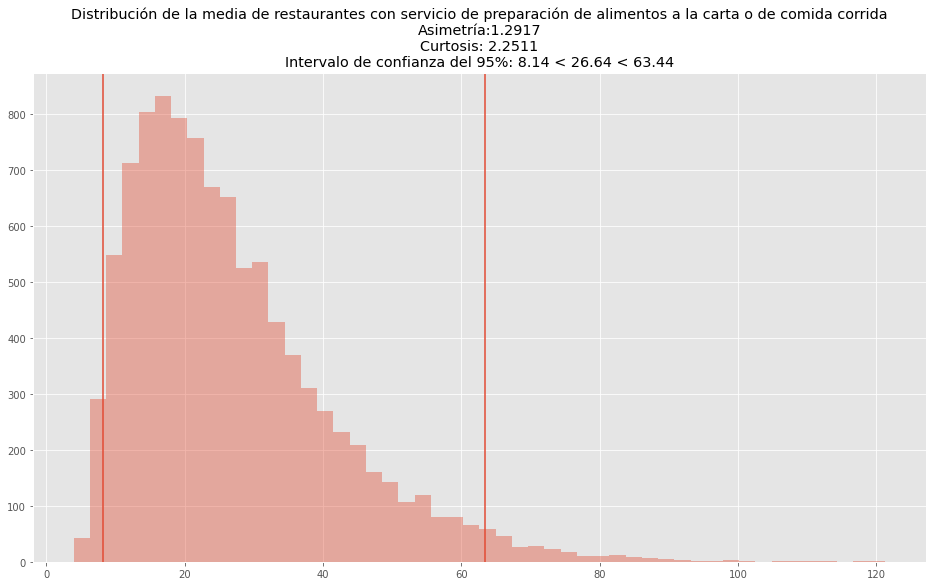

In [ ]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes con servicio de preparación de alimentos a la carta o de comida corrida\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}\nIntervalo de confianza del 95%: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}');

#### Restaurantes con servicio de preparación de antojitos

In [ ]:
rest_antojitos = df['antojitos']

means = []

for i in range(100_000):
    sample = rest_antojitos.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [ ]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 22.5 < 26.64 < 114.4
Asimetría:1.0262
Curtosis: 1.3576


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


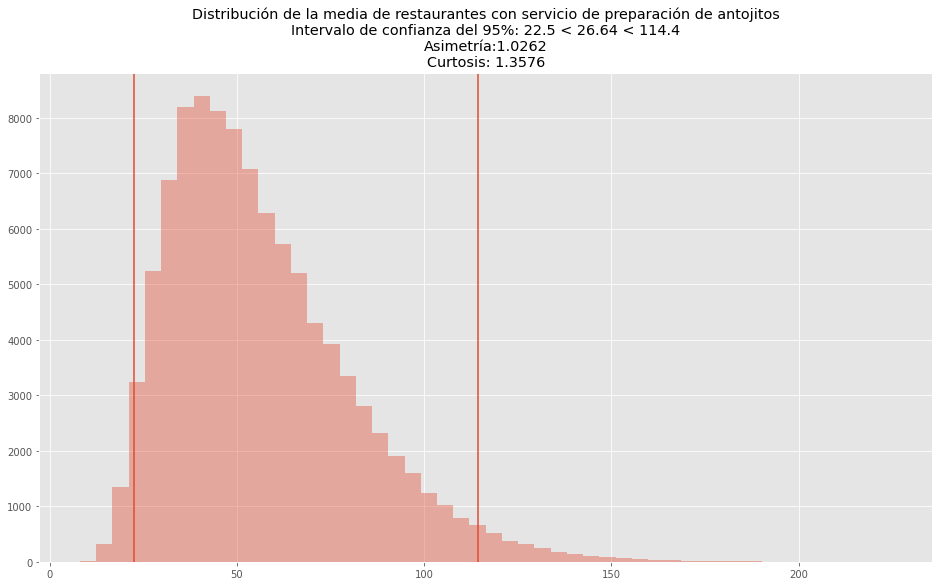

In [ ]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes con servicio de preparación de antojitos\nIntervalo de confianza del 95%: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}');

#### Restaurantes con servicio de preparación de pescados y mariscos

In [ ]:
rest_pesc = df['pescados_mariscos']

means = []

for i in range(100_000):
    sample = rest_pesc.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [ ]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 3.06 < 26.64 < 22.08
Asimetría:1.0787
Curtosis: 1.5585


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


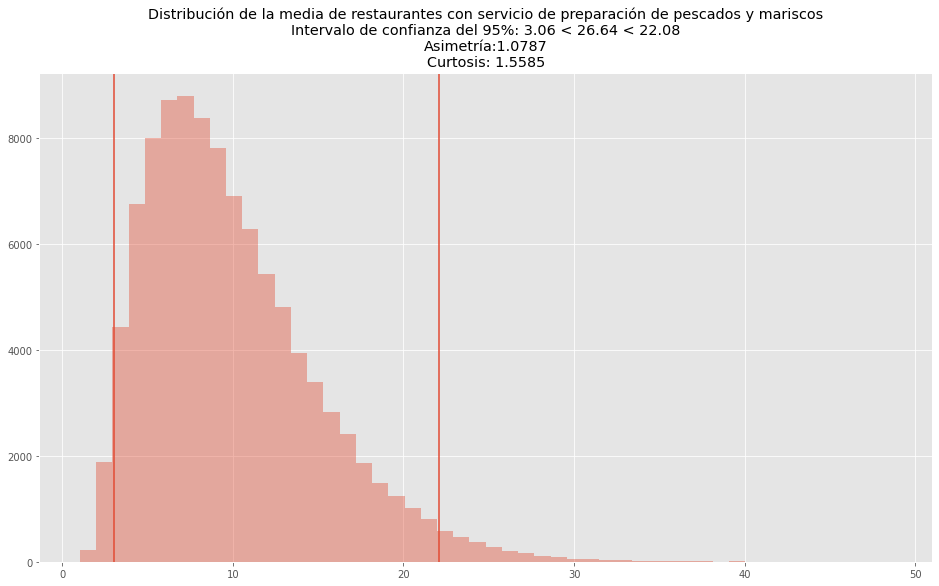

In [ ]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes con servicio de preparación de pescados y mariscos\nIntervalo de confianza del 95%: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}');

#### Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar	

In [ ]:
rest_rapida = df['pizzas_hamburguesas_hotdogs_pollos_rostizados']
means = []

for i in range(100_000):
    sample = rest_rapida.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [ ]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 10.84 < 26.64 < 55.84
Asimetría:0.9296
Curtosis: 1.0632


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


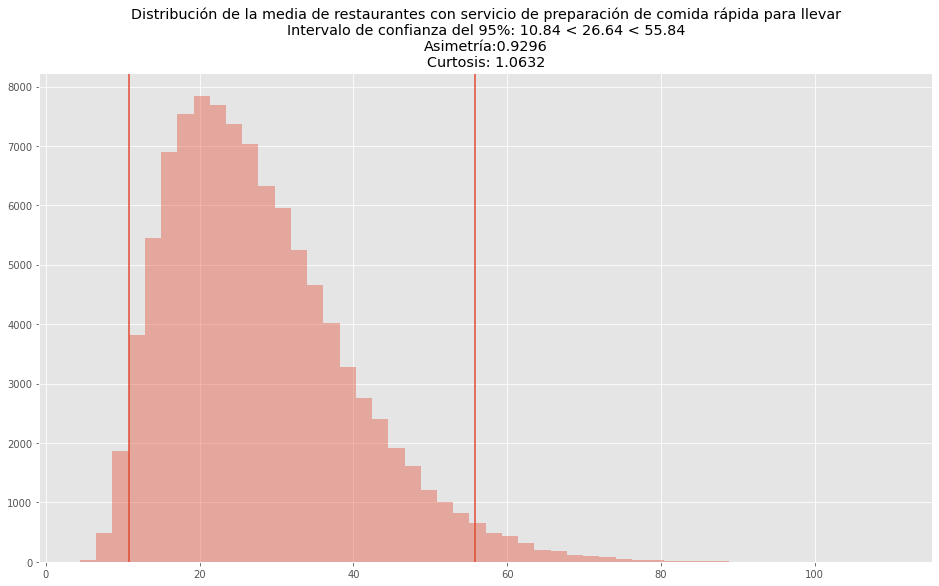

In [ ]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes con servicio de preparación de comida rápida para llevar\nIntervalo de confianza del 95%: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}');

#### Restaurantes con servicio de preparación de tacos y tortas

In [ ]:
rest_tacos = df['tacos_tortas']

means = []

for i in range(100_000):
    sample = rest_tacos.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [ ]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 20.82 < 26.64 < 116.76
Asimetría:1.1339
Curtosis: 1.7808


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


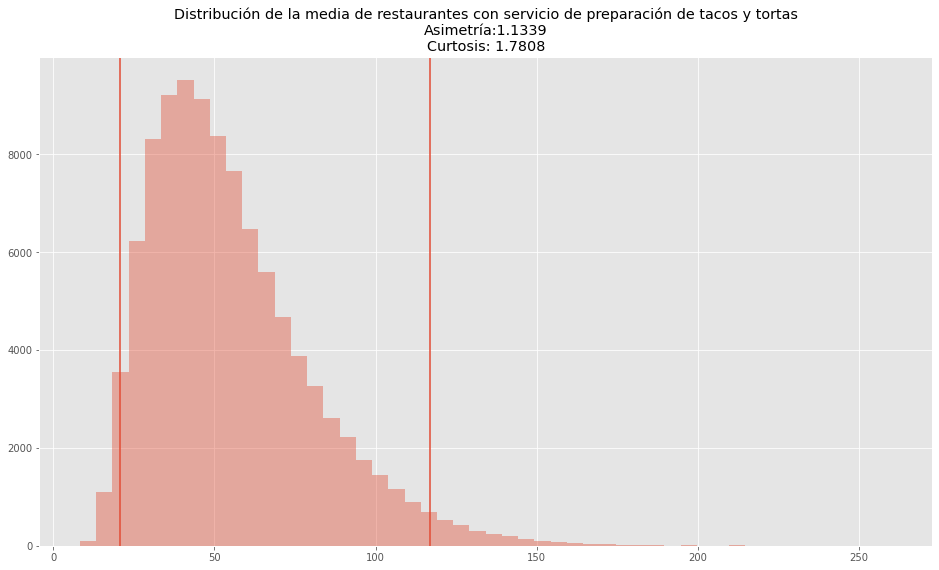

In [ ]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes con servicio de preparación de tacos y tortas\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}');

#### Restaurantes de autoservicio

In [ ]:
rest_auto = df['autoservicio']

means = []

for i in range(100_000):
    sample = rest_auto.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [ ]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 0.68 < 26.64 < 10.68
Asimetría:1.193
Curtosis: 1.7141


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


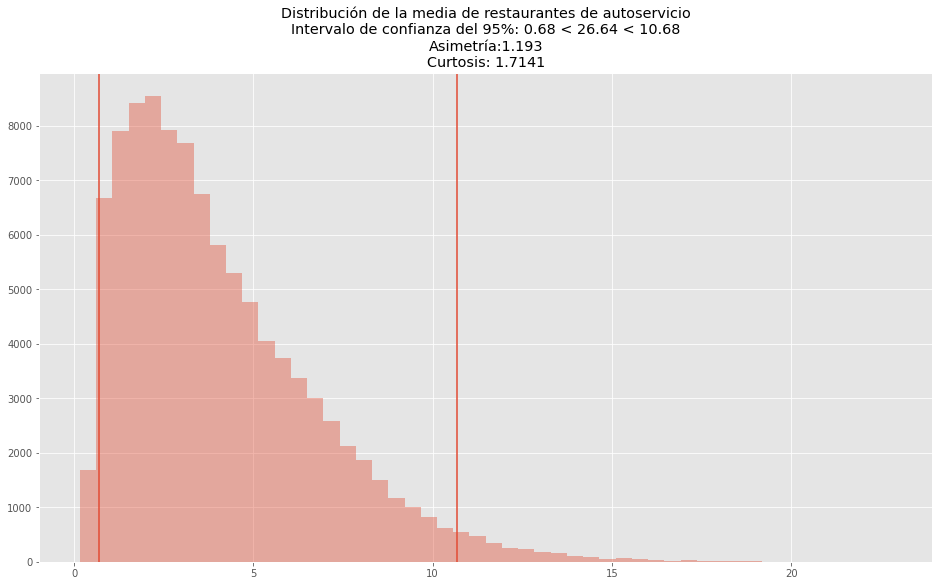

In [ ]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes de autoservicio\nIntervalo de confianza del 95%: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}');

#### Restaurantes que preparan otro tipo de alimentos para llevar

In [ ]:
rest_otro = df['otro_tipo_alimentos']

means = []

for i in range(100_000):
    sample = rest_otro.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [ ]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 8.36 < 26.64 < 59.52
Asimetría:1.304
Curtosis: 2.2012


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


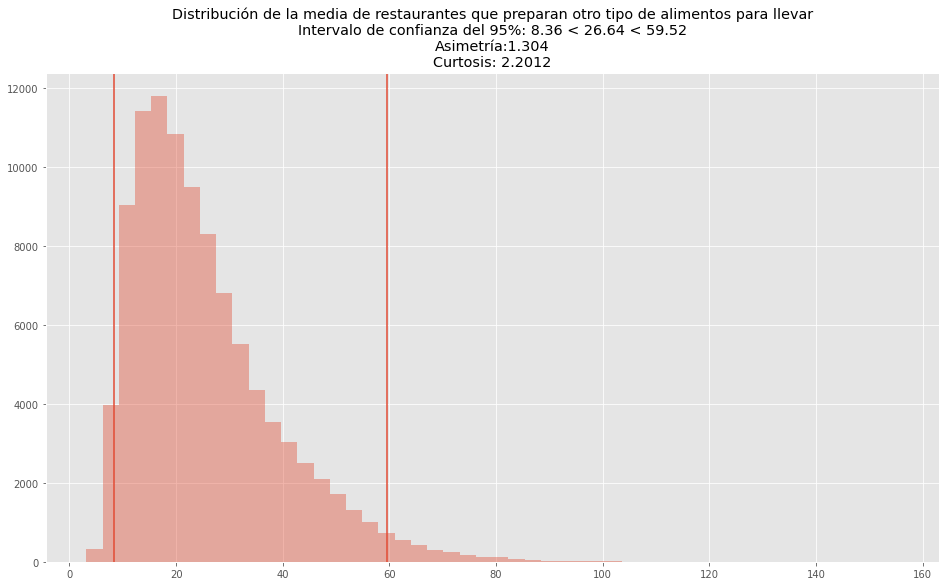

In [ ]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes que preparan otro tipo de alimentos para llevar\nIntervalo de confianza del 95%: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}');

### 3. Si tiene sentido, elige algunas de tus variables numéricas para entrenar uno o más modelos de Regresión Lineal Múltiple. Utiliza las técnicas de división de dataset y validación cruzada de K-iteraciones para asegurarte de que tu modelo generalice.

In [ ]:
''' 
Para hacer la regresión se utilizarán como variables independientes las variables de población total e ingreso laboral promedio, 
y como dependiente el total de restaurantes.
'''
df_lr = pd.DataFrame()
df_lr['total_restaurantes'] = df['pescados_mariscos'] +	df['pizzas_hamburguesas_hotdogs_pollos_rostizados'] + df['tacos_tortas'] +	df['autoservicio'] +	df['otro_tipo_alimentos']
df_lr['ing_lab'] = df['ing_lab']
df_lr['pobtot'] = df['pobtot']

In [ ]:
'''
Sólo se tomará en cuenta a los registros con ingresos laborales mayores a cero
'''
df_lr = df_lr[df_lr['ing_lab'] > 0]

In [ ]:
df_lr

,total_restaurantes,ing_lab,pobtot
2,2178.0,7676.46,877190.0
3,56.0,5863.52,46464.0
4,94.0,5784.97,56048.0
5,17.0,6096.05,15577.0
6,266.0,6262.18,120405.0
...,...,...,...
2489,29.0,6558.72,18745.0
2490,20.0,3762.57,13099.0
2491,21.0,1877.31,19155.0
2493,440.0,7421.03,146147.0


In [ ]:
# Ahora procedemos a realizar el modelo de regresión lineal con nuestras variables
from sklearn.model_selection import train_test_split

In [ ]:
X = df_lr[['pobtot', 'ing_lab']]
y = df_lr['total_restaurantes']

X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X_training, y_training)
print(f'Score del modelo: {lr.score(X_test, y_test):.4f}')

Score del modelo: 0.8251


In [ ]:
lr_2 = LinearRegression()
lr_2.fit(X, y)
print(f'Score del modelo sin hacer la división de entrenamiento y prueba: {lr_2.score(X, y):.4f}')

Score del modelo sin hacer la división de entrenamiento y prueba: 0.8943


In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
scores = cross_validate(lr, X, y, scoring='r2')
print(f'Score del modelo con validación cruzada de K-Iteraciones: {scores["test_score"].mean():.4f} +/- {scores["test_score"].std():.4f}')

Score del modelo con validación cruzada de K-Iteraciones: 0.8732 +/- 0.0480


In [ ]:
'''
También se correrá una regresión con solamente la población total como variable dependiente y el total de restaurantes como independiente, 
ya que como se vio anteriormente el la correlación entre el número de restaurantes y el ingreso laboral es positivamente débil. 
'''
X = df_lr[['pobtot']]
y = df_lr['total_restaurantes']

X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [ ]:
lr = LinearRegression()
lr.fit(X_training, y_training)
print(f'Score del modelo: {lr.score(X_test, y_test):.4f}')

Score del modelo: 0.8877


In [ ]:
lr_2 = LinearRegression()
lr_2.fit(X, y)
print(f'Score del modelo sin hacer la división de entrenamiento y prueba: {lr_2.score(X, y):.4f}')

Score del modelo sin hacer la división de entrenamiento y prueba: 0.8937


In [ ]:
scores = cross_validate(lr, X, y, scoring='r2')
print(f'Score del modelo con validación cruzada de K-Iteraciones: {scores["test_score"].mean():.4f} +/- {scores["test_score"].std():.4f}')

Score del modelo con validación cruzada de K-Iteraciones: 0.8734 +/- 0.0489


Como se puede notar, la variable de ingreso laboral no genera un gran aumento del R^2, pues pasa de 0.8943 a 0.8937 cuando esta variable no se toma en cuenta.

## **6. Visualización de Datos Avanzada**

En esta sesión conocimos muchos nuevos tipos de gráficas que nos ayudan a explorar y entender con más detalle nuestros datos. Ojalá y hayas percibido el poder tan grande que tienen las visualizaciones y la variedad tan enorme que existe. Cada visualización tiene sus ventajas y desventajas, sus características específicas, y es importante conocerlas bien para poder elegir la gráfica adecuada para cada momento. Revisa con detenimiento si hay alguna buena razón para utilizar en tu proyecto alguna de las gráficas que aprendimos hoy. 

Aquí hay un pequeño 'cheat sheet' para tomar estas decisiones:

1. Si hay relaciones jerárquicas que quieras hacer claras o si quieres explorar las proporciones de una variable numérica agrupada en múltiples niveles utiliza un treemap.
2. Si quieres explorar la relación entre dos variables numéricas divididas por una variable categórica, utiliza scatterplots por categorías o scatterplots con variables condicionantes.
3. Si quieres explorar la relación entre dos variables numéricas pero tu dataset es tan grande que es imposible definir las densidades de tus datos, utiliza un binning hexagonal.
4. Si quieres explorar datos geográficos, como definir regiones o puntos en un mapa o visualizar una variable numérica que puede segmentarse por regiones geográficas, utiliza un mapa cloroplético.
5. Si quieres explorar una variable numérica agrupada en dos niveles por variables categóricas, utiliza una gráfica de barras apiladas.

Integración de los datos geoespaciales

In [ ]:
municipios_merge = pd.merge(mun_geo, dataframe, left_on = ['CVEGEO'], right_on = ['CVEGEO'], how = 'left')
municipios_merge.head(5)

,CVEGEO,CVE_ENT,CVE_MUN,NOM_ENT,AREA,PERIMETER,COV_,COV_ID,NOM_MUN,geometry,imun,ent,nom_ent,mun,nom_mun,pobtot,ing_lab,ocupados,desocupados,pob,pea,ocupada,tra_omun,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,pizzas_hamburguesas_hotdogs_pollos_rostizados,tacos_tortas,autoservicio,otro_tipo_alimentos
0,01001,01,001,Aguascalientes,116635.924760,256.631026,0,1,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0...",1001.0,1.0,Aguascalientes,1.0,Aguascalientes,877190.0,7676.46,300564.0,24836.0,974529.0,382550.0,367528.0,9344.0,46426.0,23283.0,23142.0,334896.0,153478.0,181418.0,402.0,2092.0,192.0,506.0,1046.0,96.0,338.0
1,01002,01,002,Aguascalientes,54337.426596,192.096428,1,2,Asientos,"POLYGON ((-102.05189 22.29144, -102.05121 22.2...",1002.0,1.0,Aguascalientes,2.0,Asientos,46464.0,5863.52,8138.0,693.0,51383.0,13914.0,13108.0,3585.0,989.0,549.0,440.0,5165.0,2023.0,3142.0,6.0,44.0,3.0,11.0,37.0,0.0,5.0
2,01003,01,003,Aguascalientes,92335.783227,171.636168,2,3,Calvillo,"POLYGON ((-102.68569 22.09963, -102.69087 22.0...",1003.0,1.0,Aguascalientes,3.0,Calvillo,56048.0,5784.97,14757.0,199.0,61389.0,20099.0,19352.0,298.0,3280.0,1750.0,1529.0,14944.0,7370.0,7573.0,14.0,122.0,4.0,26.0,58.0,2.0,4.0
3,01004,01,004,Aguascalientes,12838.354453,73.352682,3,4,Cosío,"POLYGON ((-102.28787 22.41649, -102.28753 22.4...",1004.0,1.0,Aguascalientes,4.0,Cosío,15577.0,6096.05,3801.0,87.0,17076.0,4869.0,4627.0,1579.0,1000.0,591.0,408.0,4538.0,3172.0,1366.0,0.0,27.0,3.0,2.0,10.0,0.0,2.0
4,01005,01,005,Aguascalientes,49989.509147,163.500810,4,5,Jesús María,"POLYGON ((-102.33568 22.05067, -102.33348 22.0...",1005.0,1.0,Aguascalientes,5.0,Jesús María,120405.0,6262.18,37341.0,3187.0,132340.0,51020.0,49795.0,19699.0,6377.0,3402.0,2975.0,63320.0,22688.0,40631.0,28.0,207.0,24.0,57.0,154.0,3.0,28.0


Validación de los poligonos con desagregado de color por el total de población.

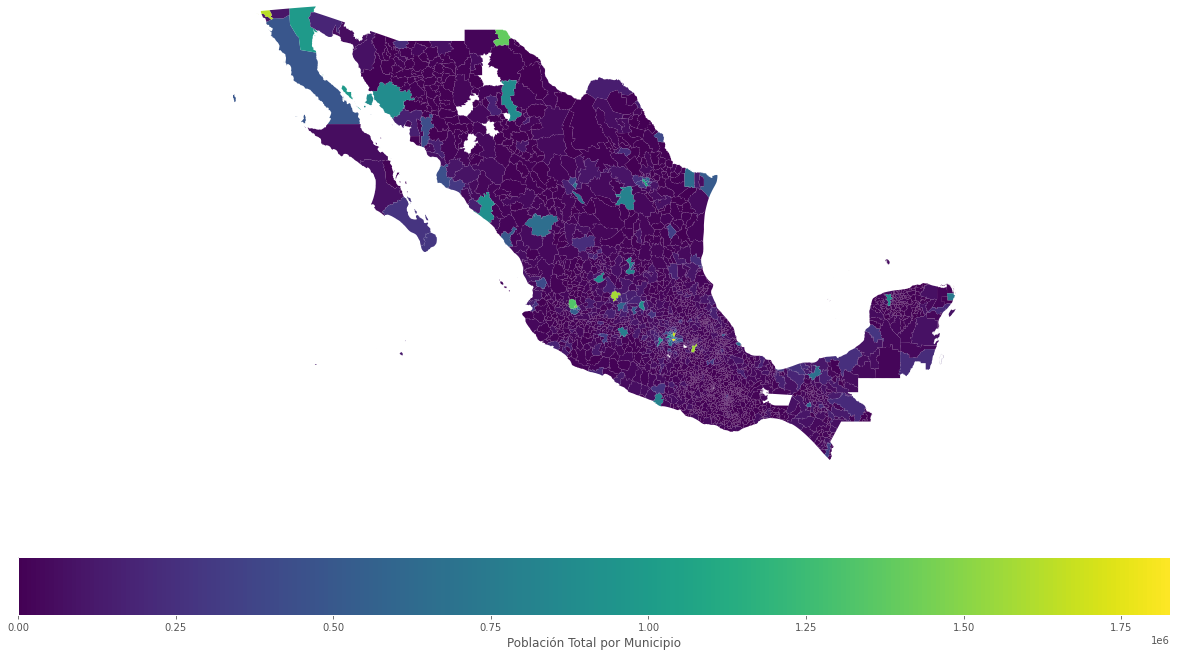

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

municipios_merge.plot(ax=ax, column='pobtot', legend=True, legend_kwds={'label': "Población Total por Municipio", 
                                                                        'orientation': "horizontal"})
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

## **7. Procesamiento de Lenguaje Natural**
En esta sesión aprendimos dos cosas: Pruebas A/B y Procesamiento de Lenguaje Natural. No podemos practicar Pruebas A/B en nuestro proyecto, porque en realidad los proyectos que estamos realizando no se prestan a esto. No pasa nada, ¡ya tendrás oportunidad de practicar eso en tu primer trabajo como científico de datos!

Por lo pronto en este Postwork vamos a practicar las técnicas de Procesamiento de Lenguaje Natural que hemos aprendido. Si tu dataset no contiene datos no estructurados, busca un dataset apropiado y realiza los siguientes ejercicios. Si tu dataset contiene datos no estructurados, entonces éste es el momento de agregar PLN a tu proyecto.

Realiza los siguientes procedimientos en caso de que apliquen a tu dataset:

1. Utiliza patrones Regex para limpiar tus datos estructurados
2. Dado que debes de conocer bien tu dataset (excepto si es un nuevo dataset que buscaste para este Postwork), es probable que tengas una idea de las palabras que son relevantes para tu tema. Genera un objeto Text con la librería nltk y explora los contextos de las palabras que elegiste. Utiliza el método similar para obtener palabras que tengan contextos similares a las palabras originales. Puede que descubras nuevas palabras que tengan relevancia para tu proyecto.
3. Utiliza el objeto FreqDist de nltk para hacer análisis estadístico de tu dataset. Explora las palabras y los bigramas más comunes de tu dataset.
4. Realiza visualizaciones de tus conteos de frecuencias utilizando gráficas de barras.
5. Realiza visualizaciones de las distribuciones de frecuencias de las longitudes de las palabras o de las oraciones.
6. Realiza nubes de palabras para detectar los temas más importantes de tu conjunto de datos.
7. Haz un análisis de sentimientos de tu conjunto de datos, de preferencia utilizando una variable categórica para segmentar tus datos y poder comparar las distribuciones de polaridades entre cada segmento.

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/Python/data/jornada_restaurantes.csv')
data

,author,body,date,keyWords,link,location,source,title
0,Redacción,"México, como muchos países está volviendo a re...","martes, 29 dic 2020 09:00","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/economia/20...,NaN,LaJornada.com,2020: Un año donde la diferencia la hicimos to...
1,"Héctor Briseño, Corresponsal","Acapulco, Gro., Los principales destinos turís...","lunes, 04 ene 2021 07:51","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/estados/202...,NaN,LaJornada.com,Cayó $3 mil millones la derrama turística dece...
2,Afp,Londres. La totalidad de los 56 millones de ha...,"jueves, 26 nov 2020 14:40","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,Londres,LaJornada.com,Inglaterra mantendrá importantes restricciones...
3,"Afp, Ap y Sputnik",Los Ángeles. En su lucha por controlar cifras ...,"jueves, 26 nov 2020 08:01","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,NaN,LaJornada.com,Millón y medio de infectados en América en una...
4,Rocío González Alvarado,Sábado 28 de noviembre de 2020. Una de las apu...,"sábado, 28 nov 2020 08:24","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/capital/202...,NaN,LaJornada.com,"""Alerta al límite del rojo"" en la CDMX: Shein..."
...,...,...,...,...,...,...,...,...
639,Néstor Jiménez y Alonso Urrutia,Ciudad de México. México es autosuficientes en...,"martes, 31 mar 2020 09:13","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/economia/20...,NaN,LaJornada.com,Multas de hasta 3 mdp por alzas irregulares en...
640,Carlos Águila Arreola/ La Jornada Maya,"Cancún. Los cines, bares, discotecas, casinos ...","miércoles, 18 mar 2020 20:03","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/estados/202...,Cancún,LaJornada.com,Cancún cerrará todo giro comercial para evitar...
641,Lilián Anaya @Lilian_Anaya,Ciudad de México. Uber Eats informó que une es...,"lunes, 23 mar 2020 16:00","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/tiempo-de-i...,Ciudad de México,LaJornada.com,"Uber Eats apoya a restaurantes, repartidores y..."
642,Ap,La Habana. Un millar de cruceristas y la tripu...,"miércoles, 18 mar 2020 15:40","'restaurantes,covid'",https://www.jornada.com.mx/ultimas/mundo/2020/...,La Habana.,LaJornada.com,Desembarcan en Cuba pasajeros de crucero recha...


In [ ]:
data['date'] = data['date'].str.replace(r'ago', 'aug')
data['date'] = data['date'].str.replace(r'abr', 'apr')
data['date'] = data['date'].str.replace(r'ene', 'jan')
data['date'] = data['date'].str.replace(r'dic', 'dec')
data['date'] = [dateutil.parser.parse(x, fuzzy_with_tokens=True)[0] for x in data['date']]
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month

In [ ]:
data_month = data.groupby(['month'])['body'].apply(' '.join).reset_index()
data_month = data_month.set_index('month')
data_month

,body
month,
1,"Acapulco, Gro., Los principales destinos turís..."
2,Seúl. Corea del Norte anunció un arsenal de me...
3,"Mérida, Yuc. Para disminuir en todo lo posible..."
4,"Teotihuacán, Méx. Un grupo de comerciantes y a..."
5,Berlín. Alemania prolongará hasta el 29 de jun...
6,Ciudad de México. De los 121 mil 765 estableci...
7,Lima. El gobierno peruano informó este miércol...
8,Londres. Las medidas para evitar la propagació...
9,Ciudad de México. Dirigentes de asociaciones d...


In [ ]:
def clean_text_round1(text):
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
 
round1 = lambda x: clean_text_round1(x)
 
data_clean = pd.DataFrame(data_month.body.apply(round1))

def clean_text_round2(text):
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text
 
round2 = lambda x: clean_text_round2(x)
 
data_clean = pd.DataFrame(data_clean.body.apply(round2))
data_clean

,body
month,
1,acapulco gro los principales destinos turís...
2,seúl corea del norte anunció un arsenal de me...
3,mérida yuc para disminuir en todo lo posible...
4,teotihuacán méx un grupo de comerciantes y a...
5,berlín alemania prolongará hasta el de junio...
6,ciudad de méxico de los mil establecimiento...
7,lima el gobierno peruano informó este miércol...
8,londres las medidas para evitar la propagació...
9,ciudad de méxico dirigentes de asociaciones d...


In [ ]:
import base64
import requests

master = "https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/Python/data/spanish.txt"
req = requests.get(master)
lines = req.text.split(sep='\n')

In [ ]:
cv = CountVectorizer(stop_words=lines)
data_cv = cv.fit_transform(data_clean.body)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
 
data_dtm

,abad,abajo,abandonados,abandonando,abandonar,abandonaron,abandonen,abandonó,abanico,abaratamiento,abarca,abarrotadas,abarrotado,abarrotados,abarrotaron,abarrotará,abarrotes,abarrotó,abascal,abasolo,abastecedor,abastecen,abastecer,abastecerse,abastecimiento,abasto,abastos,abatir,abbot,abbott,abc,abdo,abdool,abdulá,abel,abelardo,abierta,abiertamente,abiertas,abierto,...,ésto,éstos,étnico,éxito,éxodo,íbamos,índice,índices,índico,íntegro,íñigo,ópera,ópticas,óptimas,óptimo,órdenes,órgano,órganos,óscar,última,últimas,último,últimos,única,únicamente,únicas,único,únicos,úrkullu,útil,útiles,𝐋𝐢𝐧𝐞𝐚𝐦𝐢𝐞𝐧𝐭𝐨,𝐍𝐚𝐜𝐢𝐨𝐧𝐚𝐥,𝐑𝐞𝐚𝐩𝐞𝐫𝐭𝐮𝐫𝐚,𝐒𝐞𝐜𝐭𝐨𝐫,𝐓𝐮𝐫𝐢,𝐝𝐞𝐥,𝐥𝐚,𝐩𝐚𝐫𝐚,𝐬𝐭𝐢𝐜𝐨
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,0,5,0,0,0,0,0,0,1,0,9,1,0,0,0,0,0,0,0,0,0,1,0,3,3,...,0,1,2,3,0,0,1,0,0,1,2,0,0,1,0,2,1,4,1,11,10,10,11,3,4,0,3,0,2,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,2,0,0,1,0,1,0,0,0,12,0,0,0,0,0,2,0,0,8,0,0,0,1,0,0,0,0,2,1,1,0,1,1,...,0,3,0,0,1,1,2,0,0,0,0,0,0,0,0,3,0,0,1,4,7,9,4,0,4,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,2,7,...,0,0,0,4,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,2,33,12,13,3,6,0,2,1,0,0,0,1,1,1,1,1,1,1,1,1
6,0,2,0,0,2,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,0,1,0,3,6,...,1,1,0,2,0,1,2,2,1,0,0,0,0,1,0,4,0,1,0,4,15,8,13,1,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,0,0,0,1,1,2,1,...,0,2,0,1,0,0,2,1,0,0,0,0,2,0,0,1,0,0,0,4,14,6,6,4,4,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,2,0,0,0,1,2,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,3,3,3,1,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,...,0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,4,9,2,7,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
dt_data = data_dtm.transpose()
dt_data.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
abad,0,0,0,0,1,0,0,0,0,0,0,0
abajo,0,0,0,0,0,2,1,0,0,0,0,0
abandonados,0,0,1,1,0,0,0,0,0,0,0,0
abandonando,0,0,0,0,0,0,0,1,0,0,0,0
abandonar,0,0,1,1,1,2,1,0,0,0,1,0


In [ ]:
top_dict = {}
for c in dt_data.columns:
    top = dt_data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

for month, top_words in top_dict.items():
    print(month)
    print(', '.join([word+' '+str(count) for word, count in top_words[0:14]]))

1
mil 18, ciento 10, millones 9, pesos 9, acapulco 8, turismo 8, ocupación 7, año 7, derrama 6, playas 5, turistas 5, presidente 4, debido 4, promedio 3
2
coronavirus 10, país 9, irán 6, países 6, casos 6, corea 6, irak 5, ahora 5, según 5, saudita 5, hadj 5, año 5, norte 5, china 5
3
mil 237, covid 182, país 159, medidas 152, personas 147, restaurantes 147, gobierno 141, ciudad 139, méxico 130, salud 128, coronavirus 115, casos 112, ciento 108, pandemia 88
4
mil 179, covid 115, personas 96, pandemia 90, gobierno 88, millones 86, restaurantes 82, salud 79, país 79, coronavirus 77, méxico 73, medidas 71, ciudad 63, ciento 63
5
mil 454, covid 236, coronavirus 221, pandemia 192, ciento 166, millones 144, país 144, dos 141, restaurantes 140, personas 130, medidas 124, muertos 122, mayo 121, gobierno 119
6
ciento 242, mil 236, covid 149, restaurantes 132, casos 117, medidas 115, méxico 109, actividades 109, pandemia 104, personas 104, coronavirus 95, dijo 93, semáforo 90, ciudad 82
7
mil 19

In [ ]:
from collections import Counter

words = []
for anio in dt_data.columns:
    top = [word for (word, count) in top_dict[anio]]
    for t in top:
        words.append(t)
print(Counter(words).most_common())
add_stop_words = [word for word, count in Counter(words).most_common() if count > 6]
add_stop_words

[('mil', 11), ('millones', 11), ('covid', 11), ('país', 11), ('ciento', 10), ('pandemia', 10), ('casos', 10), ('personas', 10), ('méxico', 10), ('coronavirus', 9), ('medidas', 9), ('restaurantes', 9), ('gobierno', 9), ('ciudad', 9), ('salud', 9), ('contagios', 8), ('número', 6), ('dijo', 6), ('actividades', 6), ('parte', 5), ('si', 5), ('según', 5), ('turismo', 4), ('año', 4), ('restricciones', 4), ('días', 4), ('semana', 4), ('dos', 4), ('autoridades', 3), ('cierre', 3), ('así', 3), ('mientras', 3), ('sector', 3), ('menos', 3), ('lunes', 3), ('turistas', 2), ('debido', 2), ('económica', 2), ('países', 2), ('centros', 2), ('virus', 2), ('servicios', 2), ('crisis', 2), ('empresas', 2), ('meses', 2), ('mundo', 2), ('europa', 2), ('reapertura', 2), ('negocios', 2), ('mayor', 2), ('horas', 2), ('bares', 2), ('confinamiento', 2), ('pesos', 1), ('acapulco', 1), ('ocupación', 1), ('derrama', 1), ('playas', 1), ('presidente', 1), ('promedio', 1), ('guerrero', 1), ('informó', 1), ('diciembre', 

['mil',
 'millones',
 'covid',
 'país',
 'ciento',
 'pandemia',
 'casos',
 'personas',
 'méxico',
 'coronavirus',
 'medidas',
 'restaurantes',
 'gobierno',
 'ciudad',
 'salud',
 'contagios']

In [ ]:
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

stop_words = req.text.split(sep='\n')
for pal in add_stop_words:
    stop_words.append(pal)
more_stop_words=['día','nuevo','según','si','hora','año','function', 'recomendamos', 'west', 'texas', 'wti', 'además', 'intermediate', 'display','ad','gpt','dijo','div','más','también', 'interarticle','pues','parte','está', 'cmd', 'push', 'googletag','alex','lucas','andrés','mirta','tres','primer','primera','dos','uno','veces', 'así', 'luego', 'quizá','cosa','cosas','tan','asi','andres','todas','sólo','jesús','pablo','pepe']
for pal in more_stop_words:
    stop_words.append(pal)

cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.body)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['texas', 'wti'] not in stop_words.



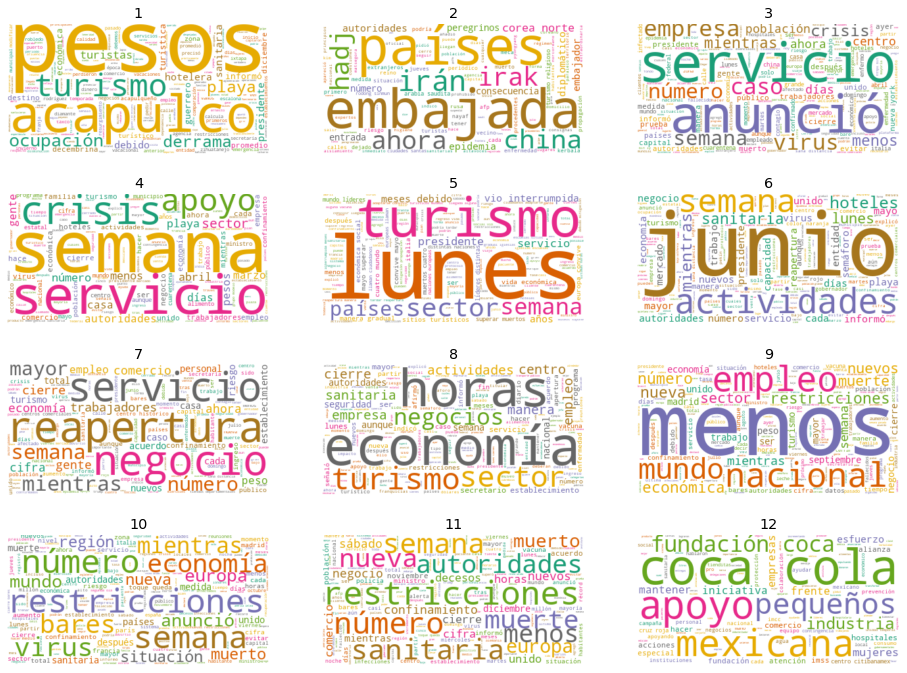

In [ ]:
from wordcloud import WordCloud
anios = ['1','2','3','4','5','6','7','8','9','10','11','12']

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,12]

for index, mes in enumerate(dt_data.columns):
    wc.generate(data_clean.body[mes])
    plt.subplot(4, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(anios[index])
plt.show()

## **8. Clasificación No Supervisada y Supervisada**

En este Postwork haremos dos cosas: practicar la aplicación del algoritmo de Regresión Logística y resolver dudas generales sobre tu proyecto. Realiza los siguientes pasos:

1. Si hay un problema de clasificación binaria en tu proyecto, ¡genial! Aplica lo aprendido en esta sesión y entrena un modelo de Regresión Logística con tu dataset.
2. Si no hay un problema de clasificación binaria en tu proyecto, pídele ayuda a la experta para conseguir un dataset con el que puedas practicar.
3. Evalúa tu modelo de Regresión Logística utilizando matriz de confusión; medidas de precisión, exactitud, sensibilidad y especificidad; y curva ROC / AUC.
> Ojo: si tu proyecto tiene un problema de clasificación multiclase (es decir, la variable dependiente no es binaria sino que contiene más de 2 categorías posibles), pídele ayuda a la experta para aplicar el algoritmo de Regresión Logística Multiclase.



## **Normalización de los datos**

In [ ]:
scaler=StandardScaler()
df = dataframe.drop(['imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO','pob','tra_omun','ocupados','desocupados'], axis=1)
scaler.fit(df) # Calcula la media y estandar para cada dimensión
X_scaled=scaler.transform(df) # Transforma los datos a su nueva escala

In [ ]:
X_scaled

array([[ 5.95305159,  1.85611559,  5.01860782, ...,  5.55637898,
         4.78941113,  3.23752362],
       [-0.01594717,  1.25968944, -0.19328157, ..., -0.10190346,
        -0.21129443, -0.21257966],
       [ 0.05291655,  1.23384784, -0.07531157, ...,  0.01586059,
        -0.10711306, -0.22294033],
       ...,
       [ 0.70030307,  1.7720835 ,  0.51760398, ...,  0.93554178,
         1.45560742,  0.19148649],
       [-0.21031618,  1.48126596, -0.2131185 , ..., -0.25331439,
        -0.21129443, -0.26438302],
       [-0.33071991, -0.669308  , -0.33832461, ..., -0.28696126,
        -0.15920374, -0.26438302]])

## **Busquéda de los componentes principales con algoritmo PCA**

In [ ]:
pca=PCA(n_components=5)
#pca=PCA(.85)
pca.fit(X_scaled) # Buscar los componentes principales
X_pca=pca.transform(X_scaled) 
#Se revisa la forma del array
print("shape of X_pca", X_pca.shape)

shape of X_pca (2452, 5)


### **Varianza explicada**

Varianza explicada del **97%**con los componentes principales calculados en el segmento de código anterior.

In [ ]:
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:5]))
# Con 5 componentes tenemos algo mas del 97% de varianza explicada

[0.85116182 0.04773368 0.0384148  0.01976737 0.01414493]
suma: 0.9712226053059392


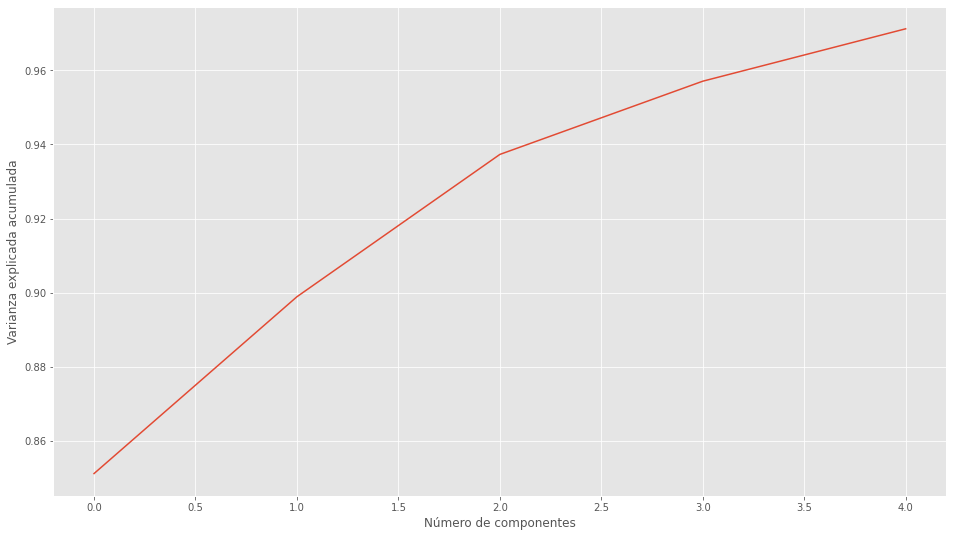

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.show()

No handles with labels found to put in legend.


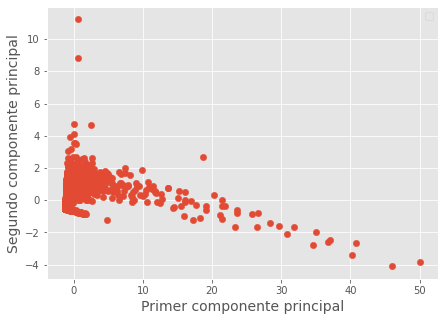

In [ ]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')

ax.scatter(Xax,Yax,s=40)

plt.xlabel("Primer componente principal",fontsize=14)
plt.ylabel("Segundo componente principal",fontsize=14)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """


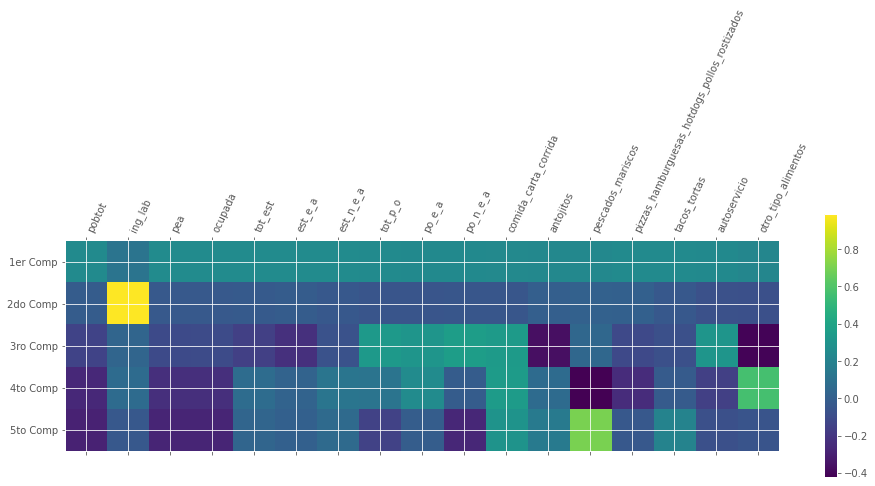

In [ ]:
plt.matshow(pca.components_[0:5],cmap='viridis')
plt.yticks([0,1,2,3,4],['1er Comp','2do Comp','3ro Comp','4to Comp','5to Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(df.columns)),df.columns,rotation=65,ha='left')
plt.tight_layout()
plt.show()# 

In [ ]:
components = pd.DataFrame(pca.components_, columns = df.columns)
components.shape

(5, 17)

## **Algoritmo K-MEANS**

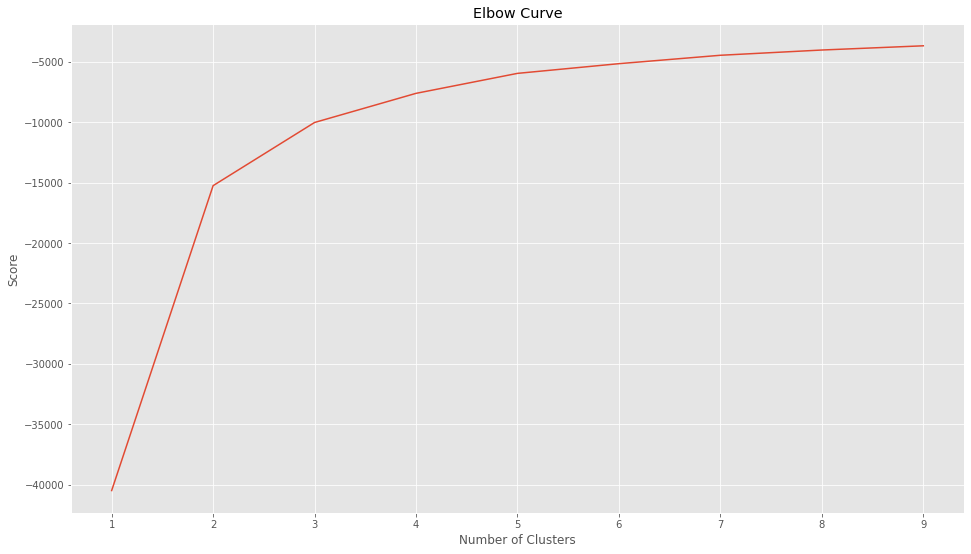

In [ ]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_pca).score(X_pca) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
# Para el proyecto, se eligio el valor 3 como un buen valor de K. Pero podría ser otro.
kmeans = KMeans(n_clusters=3).fit(X_pca)
centroids = kmeans.cluster_centers_
print(centroids)

[[-6.47861885e-01 -3.66365755e-03  9.82095256e-03  6.86851068e-03
   1.58996606e-03]
 [ 9.77377681e+00  5.83682978e-01 -4.97422797e-01 -1.96842231e-01
  -1.50152800e-02]
 [ 2.99347619e+01 -1.63612765e+00  7.39529776e-01  1.14737231e-03
  -1.04116976e-01]]


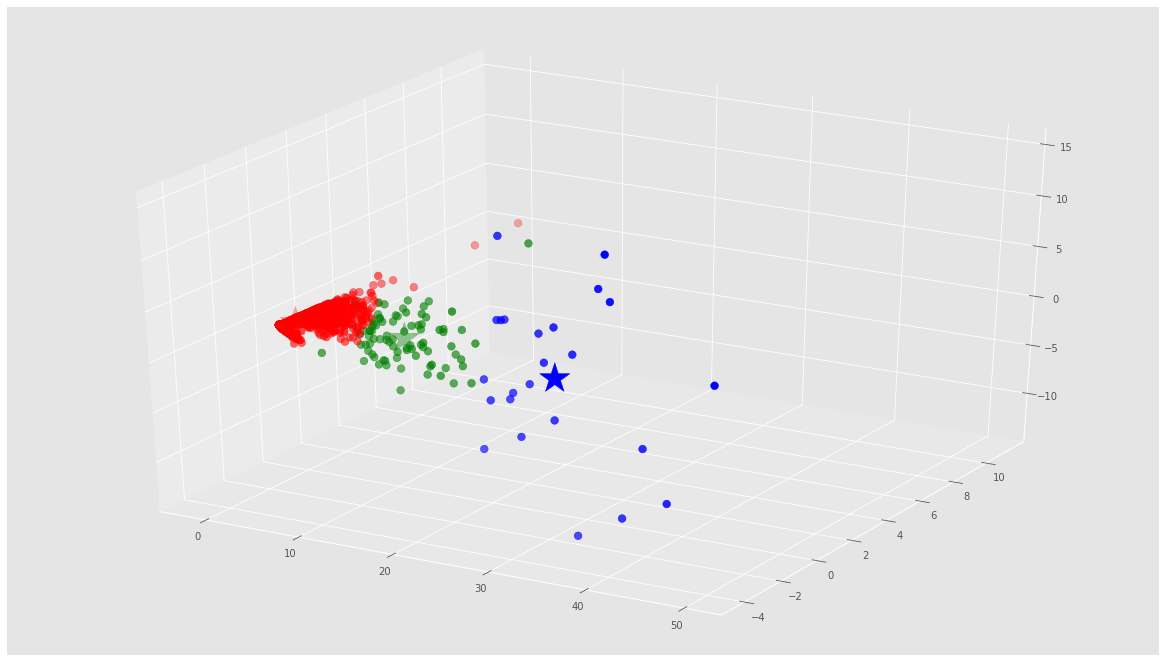

In [ ]:
# Se obtienen las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X_pca)
# Se obtienen los centroids
C = kmeans.cluster_centers_
#colores=['red','green','blue','cyan','yellow','black','white']
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [ ]:
# Se cuentan los usuarios que hay en cada grupo
copy =  pd.DataFrame()
copy['imun']=dataframe['imun'].values
copy['ent']=dataframe['ent'].values
copy['nom_ent']=dataframe['nom_ent'].values
copy['mun']=dataframe['mun'].values
copy['nom_mun']=dataframe['nom_mun'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,2346
1,green,82
2,blue,24


In [ ]:
copy.head()

,imun,ent,nom_ent,mun,nom_mun,label
0,1001,1,Aguascalientes,1.0,Aguascalientes,2
1,1002,1,Aguascalientes,2.0,Asientos,0
2,1003,1,Aguascalientes,3.0,Calvillo,0
3,1004,1,Aguascalientes,4.0,Cosío,0
4,1005,1,Aguascalientes,5.0,Jesús María,0


In [ ]:
# creating a list of column names 
#column_values = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10'] 
column_values = ['C1','C2','C3','C4','C5']  
# creating the dataframe 
df_pca = pd.DataFrame(data = X_pca,    
                  columns = column_values) 

In [ ]:
df_pca['CVEGEO']=dataframe['CVEGEO'].values
df_pca['imun']=dataframe['imun'].values
df_pca['ent']=dataframe['ent'].values
df_pca['nom_ent']=dataframe['nom_ent'].values
df_pca['mun']=dataframe['mun'].values
df_pca['nom_mun']=dataframe['nom_mun'].values
df_pca['label'] = labels;
df_pca

,C1,C2,C3,C4,C5,CVEGEO,imun,ent,nom_ent,mun,nom_mun,label
0,23.565133,-0.603083,-2.675335,-1.076158,0.373741,01001,1001,1,Aguascalientes,1.0,Aguascalientes,2
1,-0.484716,1.327360,0.002054,-0.017029,-0.151936,01002,1002,1,Aguascalientes,2.0,Asientos,0
2,0.200191,1.235793,-0.131361,0.041620,-0.127351,01003,1003,1,Aguascalientes,3.0,Calvillo,0
3,-0.722786,1.422578,0.103840,0.107073,-0.054698,01004,1004,1,Aguascalientes,4.0,Cosío,0
4,2.158376,1.172361,0.105704,-0.084749,-0.314488,01005,1005,1,Aguascalientes,5.0,Jesús María,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2447,-0.997784,0.069086,0.046359,-0.066456,-0.031884,32054,32054,32,Zacatecas,54.0,Villa Hidalgo,0
2448,-0.306471,-0.610230,-0.166206,-0.077456,0.179708,32055,32055,32,Zacatecas,55.0,Villanueva,0
2449,4.104201,1.283862,0.687706,0.086462,0.208120,32056,32056,32,Zacatecas,56.0,Zacatecas,0
2450,-0.741190,1.575821,0.074733,0.061290,-0.102560,32057,32057,32,Zacatecas,57.0,Trancoso,0


Interpretación: Los municipios agrupados en la etiqueta 2, son municipios con mayor número de población. (Se deben corroborar los otros atributos) 

In [ ]:
mask = (df_pca.label == 2)
df_pca.loc[mask]

,C1,C2,C3,C4,C5,CVEGEO,imun,ent,nom_ent,mun,nom_mun,label
0,23.565133,-0.603083,-2.675335,-1.076158,0.373741,01001,1001,1,Aguascalientes,1.0,Aguascalientes,2
12,21.400803,-0.329685,3.936010,-4.112541,-0.545686,02002,2002,2,Baja California,2.0,Mexicali,2
14,37.112183,-2.460583,9.984654,-5.537009,-3.777431,02004,2004,2,Baja California,4.0,Tijuana,2
219,21.917665,-0.365554,4.037406,-3.113662,-1.522512,08019,8019,8,Chihuahua,19.0,Chihuahua,2
236,29.725902,-1.577123,5.629828,-6.523724,-6.171089,08037,8037,8,Chihuahua,37.0,Juárez,2
268,26.520085,-1.677368,-5.563894,1.887875,-1.061942,09005,9005,9,Ciudad de México,5.0,Gustavo A. Madero,2
270,40.245829,-3.423418,-9.683480,-0.103534,-1.991427,09007,9007,9,Ciudad de México,7.0,Iztapalapa,2
278,36.822634,-2.580933,14.486965,13.717421,2.744706,09015,9015,9,Ciudad de México,15.0,Cuauhtémoc,2
279,20.271136,0.346274,11.322924,6.520818,-1.506841,09016,9016,9,Ciudad de México,16.0,Miguel Hidalgo,2
339,40.771146,-2.631483,-3.460358,-4.516455,0.095906,11020,11020,11,Guanajuato,20.0,León,2


In [ ]:
y = df_pca['label']
X = df_pca.drop(['label','imun','ent','mun'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [ ]:
mun_pca_merge = pd.merge(mun_geo, df_pca, left_on = ['CVEGEO'], right_on = ['CVEGEO'], how = 'left')

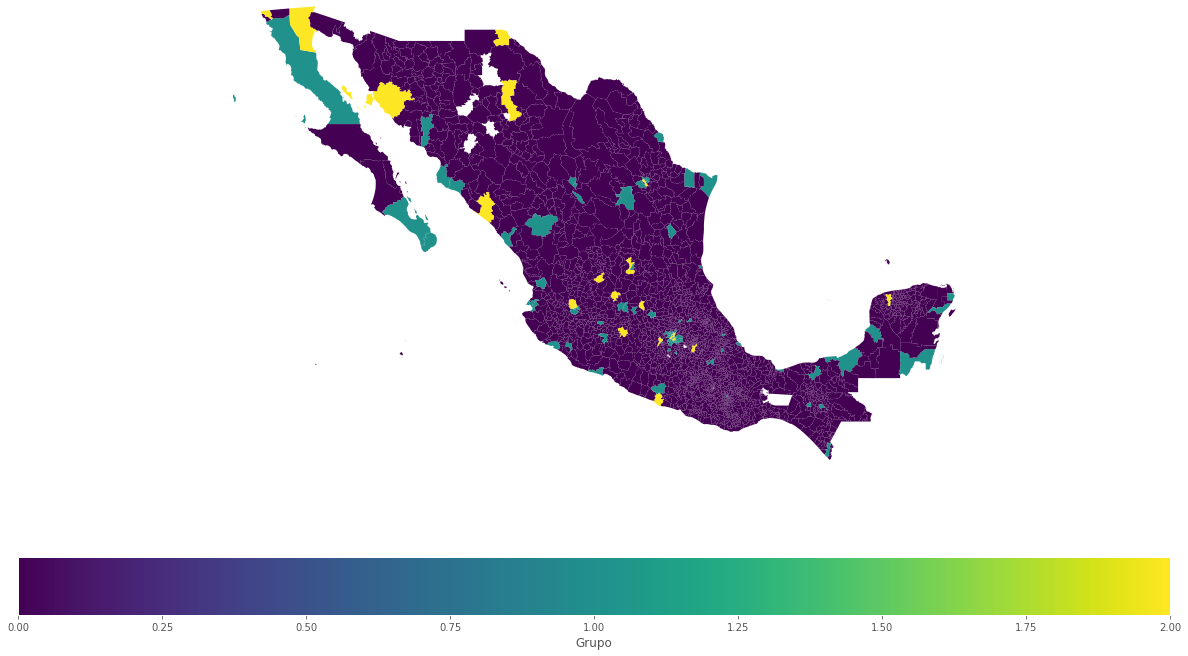

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

mun_pca_merge.plot(ax=ax, column='label', legend=True, legend_kwds={'label': "Grupo", 
                                                                        'orientation': "horizontal"})
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

**NOTA**: Checar código para la creación de mapas con folium. No muestra nada y se reinicia el kernel de Google Colab. Probablemente, por el tamaño de los polígonos.

In [ ]:
mun_geo["CVEGEO"].unique()
df_pca["CVEGEO"] = df_pca["imun"].apply(lambda x: str(x) if len(str(x)) == 5 else f"0{x}" )

mergeDat = mun_geo.merge(df_pca, on="CVEGEO")
mergeDat.head(5)

,CVEGEO,CVE_ENT,CVE_MUN,NOM_ENT,AREA,PERIMETER,COV_,COV_ID,NOM_MUN,geometry,C1,C2,C3,C4,C5,imun,ent,nom_ent,mun,nom_mun,label
0,01001,01,001,Aguascalientes,116635.924760,256.631026,0,1,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0...",24.968568,1.857848,-0.329889,-4.392862,0.432355,1001,1,Aguascalientes,1.0,Aguascalientes,1
1,01002,01,002,Aguascalientes,54337.426596,192.096428,1,2,Asientos,"POLYGON ((-102.05189 22.29144, -102.05121 22.2...",-0.496213,-1.120566,-0.681076,-0.010029,0.096461,1002,1,Aguascalientes,2.0,Asientos,0
2,01003,01,003,Aguascalientes,92335.783227,171.636168,2,3,Calvillo,"POLYGON ((-102.68569 22.09963, -102.69087 22.0...",0.115745,-0.831650,-0.825270,-0.346818,0.255686,1003,1,Aguascalientes,3.0,Calvillo,0
3,01004,01,004,Aguascalientes,12838.354453,73.352682,3,4,Cosío,"POLYGON ((-102.28787 22.41649, -102.28753 22.4...",-0.830107,-1.070022,-0.894437,-0.028943,0.250582,1004,1,Aguascalientes,4.0,Cosío,0
4,01005,01,005,Aguascalientes,49989.509147,163.500810,4,5,Jesús María,"POLYGON ((-102.33568 22.05067, -102.33348 22.0...",2.437524,-1.272341,-0.368314,0.694334,0.095136,1005,1,Aguascalientes,5.0,Jesús María,0


In [ ]:
mergeDatCorr = mergeDat.to_crs(epsg=4326)
x_map=mergeDatCorr.centroid.x.mean()
y_map=mergeDatCorr.centroid.y.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
import folium
m = folium.Map(location=[48, -102], zoom_start=3, width='60%', height='60%')

folium.Choropleth(
    geo_data=mergeDatCorr,
    name='choropleth',
    data=mergeDatCorr,
    columns=['CVEGEO', 'label'],
    key_on='CVEGEO',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='label'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [ ]:
y = df_pca['label']
X = df_pca.drop(['label','imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [ ]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

In [ ]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

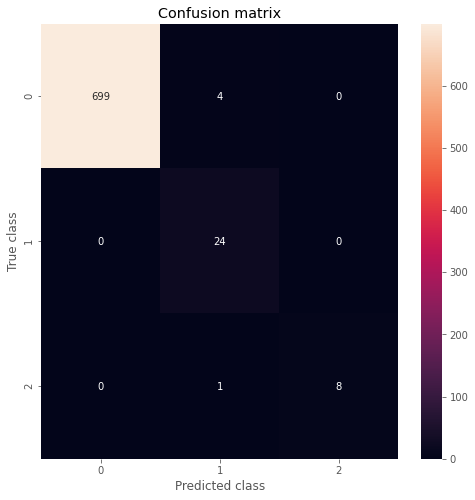

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       703
           1       0.83      1.00      0.91        24
           2       1.00      0.89      0.94         9

    accuracy                           0.99       736
   macro avg       0.94      0.96      0.95       736
weighted avg       0.99      0.99      0.99       736



In [ ]:
LABELS = [0,1,2]
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [ ]:
### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# otro modelo, variando hiperparámetros
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=2, max_depth=6,
                               oob_score=True, random_state=50)
# a entrenar
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=50, verbose=2,
                       warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


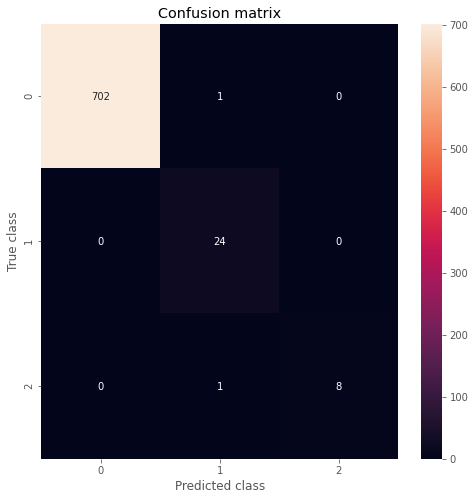

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       703
           1       0.92      1.00      0.96        24
           2       1.00      0.89      0.94         9

    accuracy                           1.00       736
   macro avg       0.97      0.96      0.97       736
weighted avg       1.00      1.00      1.00       736



In [ ]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)